In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Reshape, UpSampling1D, InputLayer
from tensorflow.keras.optimizers import Adam
df = pd.read_csv('data.csv')
df

FT001  FT003     TT002     TT006   TT006.1     TT007     TT013  \
0     0.039216  0.314  0.716667  0.068966  0.068966  0.714286  0.943925   
1     0.039216  0.314  0.750000  0.068966  0.068966  0.714286  0.943925   
2     0.036765  0.315  0.766667  0.068966  0.068966  0.714286  0.943925   
3     0.036765  0.314  0.800000  0.068966  0.068966  0.714286  0.943925   
4     0.044118  0.314  0.816667  0.068966  0.068966  0.714286  0.953271   
...        ...    ...       ...       ...       ...       ...       ...   
8901  0.036765  0.312  0.716667  0.655172  0.655172  1.000000  0.897196   
8902  0.036765  0.312  0.683333  0.637931  0.637931  0.857143  0.897196   
8903  0.041667  0.314  0.683333  0.620690  0.620690  0.857143  0.897196   
8904  0.036765  0.312  0.650000  0.603448  0.603448  0.857143  0.897196   
8905  0.034314  0.312  0.633333  0.568966  0.568966  0.857143  0.897196   

         FT002     PT007  INTENSIDAD      V001  
0     0.321429  0.692308    0.227699  0.475630  
1     0.107143  0.730769    0.227699  0.482353  
2     0.321429  0.730769    0.227699  0.482353  
3     0.321429  0.730769    0.227699  0.478992  
4     0.107143  0.730769    0.227699  0.489076  
...        ...       ...         ...       ...  
8901  0.285714  0.384615    0.227681  0.584874  
8902  0.500000  0.384615    0.227681  0.583193  
8903  0.321429  0.384615    0.227681  0.581513  
8904  0.428571  0.384615    0.227681  0.583193  
8905  0.785714  0.423077    0.227681  0.578151  

[8906 rows x 11 columns]

In [2]:
%matplotlib inline
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import matplotlib.pyplot as plt # for plotting

In [3]:
times = sorted(df.index.values)
last_20pct = sorted(df.index.values)[-int(0.1*len(times))] 
last_40pct = sorted(df.index.values)[-int(0.2*len(times))] 
train = df[(df.index < last_40pct)]  # Training data are 80% of total data
valid = df[(df.index >= last_40pct) & (df.index < last_20pct)]
test = df[(df.index >= last_20pct)]

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(train)/len(df),2),
                                                       round(len(valid)/len(df),2),
                                                       round(len(test)/len(df),2)))

train: 0.8% | validation: 0.1% | test 0.1%


In [4]:
train.shape,valid.shape, test.shape

((7125, 11), (891, 11), (890, 11))

In [5]:
window_size=120
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [6]:
from sklearn.model_selection import train_test_split
#feature_cols = ['FT001', 'FT002', 'FT003', 'FT004','HT001','V001','INTENSIDAD']
feature_cols = df.columns
label_cols = ['V001']

x_train = train
y_train = train['V001']
x_train, y_train = make_dataset(x_train, y_train, window_size)

x_valid = valid
y_valid = valid['V001']
x_valid, y_valid = make_dataset(x_valid, y_valid, window_size)


x_test = test
y_test = test['V001']
x_test, y_test = make_dataset(x_test, y_test,window_size)

In [7]:
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(7005, 120, 11) (7005,)
(771, 120, 11) (771,)
(770, 120, 11) (770,)


In [8]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def MPE(y_true, y_pred): 
    return K.mean((y_true - y_pred) / y_true) * 100
    
def MSLE(y_true, y_pred):
    return K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1)

def RMSLE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM,GRU,Dropout
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model = Sequential()
    model.add(LSTM(16,input_shape=(x_test.shape[1], x_test.shape[2]),activation='relu', return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(16, return_sequences=True))
    model.add(Dropout(0.1))
    
    model.add(LSTM(16, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.1))

 
    model.add(Dense(1))
    model.compile(loss = RMSE, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999), metrics=[soft_acc, 'mse', 'mae', RMSE, 'mape', MPE, MSLE, RMSLE, R2])
  

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assi

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/ta

c:\users\reza\anaconda3\envs\tf7\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
import os
filename = os.path.join('tmp', 'checkpointer.ckpt')
callback = tf.keras.callbacks.ModelCheckpoint(filename, 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    callbacks=[callback, early_stop],
                    validation_data=(x_valid, y_valid))  

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:

 29/219 [==>...........................] - ETA: 57s - loss: 0.2364 - soft_acc: 0.7026 - mse: 0.0679 - mae: 0.1945 - RMSE: 0.2364 - mape: 72.4701 - MPE: -20.8464 - MSLE: 0.0372 - RMSLE: 0.1432 - R2: -0.6146Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 56/219 [======>.......................] - ETA: 49s - loss: 0.1696 - soft_acc: 0.7829 - mse: 0.0400 - mae: 0.1376 - RMSE: 0.1696 - mape: 18510.7441 - MPE: inf - MSLE: 0.0215 - RMSLE: 0.0998 - R2: 0.0299Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


110/219 [==============>...............] - ETA: 33s - loss: 0.1234 - soft_acc: 0.8440 - mse: 0.0232 - mae: 0.0991 - RMSE: 0.1234 - mape: 9434.6514 - MPE: inf - MSLE: 0.0123 - RMSLE: 0.0713 - R2: 0.4300Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


164/219 [=====================>........] - ETA: 16s - loss: 0.1052 - soft_acc: 0.8702 - mse: 0.0172 - mae: 0.0839 - RMSE: 0.1052 - mape: 6334.2471 - MPE: inf - MSLE: 0.0090 - RMSLE: 0.0601 - R2: 0.5730Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


218/219 [============================>.] - ETA: 0s - loss: 0.0949 - soft_acc: 0.8822 - mse: 0.0139 - mae: 0.0755 - RMSE: 0.0949 - mape: 4769.5386 - MPE: inf - MSLE: 0.0073 - RMSLE: 0.0539 - R2: 0.6502Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0949 - soft_acc: 0.8821 - mse: 0.0139 - mae: 0.0754 - RMSE: 0.0949 - mape: 4749.8374 - MPE: inf - MSLE: 0.0073 - RMSLE: 0.0538 - R2: 0.6506Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in dev

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 2/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 52/219 [======>.......................] - ETA: 1:31 - loss: 0.0638 - soft_acc: 0.9357 - mse: 0.0042 - mae: 0.0492 - RMSE: 0.0638 - mape: 16.1254 - MPE: -2.4121 - MSLE: 0.0019 - RMSLE: 0.0340 - R2: 0.8893Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 79/219 [=========>....................] - ETA: 1:17 - loss: 0.0608 - soft_acc: 0.9320 - mse: 0.0038 - mae: 0.0472 - RMSE: 0.0608 - mape: 16.2214 - MPE: -3.2603 - MSLE: 0.0018 - RMSLE: 0.0328 - R2: 0.8981Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


106/219 [=============>................] - ETA: 1:02 - loss: 0.0587 - soft_acc: 0.9340 - mse: 0.0036 - mae: 0.0453 - RMSE: 0.0587 - mape: 15.4317 - MPE: -2.6454 - MSLE: 0.0017 - RMSLE: 0.0315 - R2: 0.9045Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 47s - loss: 0.0574 - soft_acc: 0.9349 - mse: 0.0034 - mae: 0.0441 - RMSE: 0.0574 - mape: 14.7395 - MPE: -2.1653 - MSLE: 0.0016 - RMSLE: 0.0307 - R2: 0.9081Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


160/219 [====================>.........] - ETA: 32s - loss: 0.0564 - soft_acc: 0.9332 - mse: 0.0033 - mae: 0.0433 - RMSE: 0.0564 - mape: 17501.5703 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0302 - R2: 0.9109Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


187/219 [========================>.....] - ETA: 17s - loss: 0.0560 - soft_acc: 0.9340 - mse: 0.0033 - mae: 0.0429 - RMSE: 0.0560 - mape: 14976.4902 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0299 - R2: 0.9128Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


214/219 [============================>.] - ETA: 2s - loss: 0.0553 - soft_acc: 0.9324 - mse: 0.0032 - mae: 0.0424 - RMSE: 0.0553 - mape: 13088.9775 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0296 - R2: 0.9147Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0553 - soft_acc: 0.9325 - mse: 0.0032 - mae: 0.0424 - RMSE: 0.0553 - mape: 12795.9102 - MPE: -inf - MSLE: 0.0015 - RMSLE: 0.0296 - R2: 0.9148Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 64/219 [=======>......................] - ETA: 1:26 - loss: 0.0513 - soft_acc: 0.9458 - mse: 0.0027 - mae: 0.0391 - RMSE: 0.0513 - mape: 17495.7930 - MPE: -inf - MSLE: 0.0012 - RMSLE: 0.0272 - R2: 0.9305Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 91/219 [===========>..................] - ETA: 1:11 - loss: 0.0500 - soft_acc: 0.9457 - mse: 0.0026 - mae: 0.0381 - RMSE: 0.0500 - mape: 12309.0107 - MPE: -inf - MSLE: 0.0012 - RMSLE: 0.0265 - R2: 0.9304Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


118/219 [===============>..............] - ETA: 55s - loss: 0.0491 - soft_acc: 0.9457 - mse: 0.0025 - mae: 0.0376 - RMSE: 0.0491 - mape: 9495.2666 - MPE: -inf - MSLE: 0.0011 - RMSLE: 0.0262 - R2: 0.9317Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


172/219 [======================>.......] - ETA: 25s - loss: 0.0487 - soft_acc: 0.9424 - mse: 0.0025 - mae: 0.0372 - RMSE: 0.0487 - mape: 6518.1265 - MPE: -inf - MSLE: 0.0011 - RMSLE: 0.0259 - R2: 0.9324Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0480 - soft_acc: 0.9407 - mse: 0.0024 - mae: 0.0365 - RMSE: 0.0480 - mape: 5123.8706 - MPE: -inf - MSLE: 0.0011 - RMSLE: 0.0254 - R2: 0.9352Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executi

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 4/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 51/219 [=====>........................] - ETA: 1:32 - loss: 0.0461 - soft_acc: 0.9406 - mse: 0.0022 - mae: 0.0346 - RMSE: 0.0461 - mape: 41818.5938 - MPE: -inf - MSLE: 9.9048e-04 - RMSLE: 0.0240 - R2: 0.9423Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


103/219 [=============>................] - ETA: 1:04 - loss: 0.0446 - soft_acc: 0.9445 - mse: 0.0021 - mae: 0.0335 - RMSE: 0.0446 - mape: 20712.4824 - MPE: -inf - MSLE: 9.3114e-04 - RMSLE: 0.0233 - R2: 0.9454Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


155/219 [====================>.........] - ETA: 35s - loss: 0.0441 - soft_acc: 0.9421 - mse: 0.0020 - mae: 0.0331 - RMSE: 0.0441 - mape: 13767.5225 - MPE: -inf - MSLE: 9.0892e-04 - RMSLE: 0.0230 - R2: 0.9457Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


207/219 [===========================>..] - ETA: 6s - loss: 0.0441 - soft_acc: 0.9444 - mse: 0.0020 - mae: 0.0330 - RMSE: 0.0441 - mape: 10312.0254 - MPE: -inf - MSLE: 9.1124e-04 - RMSLE: 0.0229 - R2: 0.9457Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0441 - soft_acc: 0.9452 - mse: 0.0020 - mae: 0.0329 - RMSE: 0.0441 - mape: 9751.8545 - MPE: -inf - MSLE: 9.1218e-04 - RMSLE: 0.0229 - R2: 0.9455Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 5/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:48 - loss: 0.0418 - soft_acc: 0.9475 - mse: 0.0018 - mae: 0.0302 - RMSE: 0.0418 - mape: 11.0635 - MPE: -2.4216 - MSLE: 8.1339e-04 - RMSLE: 0.0209 - R2: 0.9484Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 1:19 - loss: 0.0418 - soft_acc: 0.9513 - mse: 0.0018 - mae: 0.0305 - RMSE: 0.0418 - mape: 10.9375 - MPE: -2.5463 - MSLE: 8.1564e-04 - RMSLE: 0.0211 - R2: 0.9516Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 50s - loss: 0.0417 - soft_acc: 0.9516 - mse: 0.0018 - mae: 0.0307 - RMSE: 0.0417 - mape: 10.8399 - MPE: -2.2605 - MSLE: 8.1070e-04 - RMSLE: 0.0212 - R2: 0.9511Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


182/219 [=======================>......] - ETA: 20s - loss: 0.0410 - soft_acc: 0.9490 - mse: 0.0017 - mae: 0.0304 - RMSE: 0.0410 - mape: 1391.4153 - MPE: inf - MSLE: 7.8815e-04 - RMSLE: 0.0210 - R2: 0.9526Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


209/219 [===========================>..] - ETA: 5s - loss: 0.0409 - soft_acc: 0.9505 - mse: 0.0017 - mae: 0.0302 - RMSE: 0.0409 - mape: 1212.9396 - MPE: inf - MSLE: 7.7926e-04 - RMSLE: 0.0209 - R2: 0.9534Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0408 - soft_acc: 0.9512 - mse: 0.0017 - mae: 0.0302 - RMSE: 0.0408 - mape: 1158.5823 - MPE: inf - MSLE: 7.7750e-04 - RMSLE: 0.0209 - R2: 0.9536Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exec

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 6/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:50 - loss: 0.0381 - soft_acc: 0.9563 - mse: 0.0015 - mae: 0.0285 - RMSE: 0.0381 - mape: 9.9053 - MPE: -1.0414 - MSLE: 6.8685e-04 - RMSLE: 0.0198 - R2: 0.9600 Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 1:20 - loss: 0.0380 - soft_acc: 0.9562 - mse: 0.0015 - mae: 0.0281 - RMSE: 0.0380 - mape: 10.0963 - MPE: -1.9572 - MSLE: 6.6830e-04 - RMSLE: 0.0194 - R2: 0.9618Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 50s - loss: 0.0372 - soft_acc: 0.9518 - mse: 0.0014 - mae: 0.0278 - RMSE: 0.0372 - mape: 20032.0020 - MPE: -inf - MSLE: 6.5729e-04 - RMSLE: 0.0193 - R2: 0.9627Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 21s - loss: 0.0370 - soft_acc: 0.9518 - mse: 0.0014 - mae: 0.0276 - RMSE: 0.0370 - mape: 14280.0293 - MPE: -inf - MSLE: 6.5180e-04 - RMSLE: 0.0192 - R2: 0.9625Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0368 - soft_acc: 0.9518 - mse: 0.0014 - mae: 0.0273 - RMSE: 0.0368 - mape: 11809.1455 - MPE: -inf - MSLE: 6.4804e-04 - RMSLE: 0.0190 - R2: 0.9627Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Ex

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 7/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 25/219 [==>...........................] - ETA: 1:48 - loss: 0.0347 - soft_acc: 0.9600 - mse: 0.0012 - mae: 0.0261 - RMSE: 0.0347 - mape: 9.3572 - MPE: -1.6374 - MSLE: 5.6271e-04 - RMSLE: 0.0180 - R2: 0.9701Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


 77/219 [=========>....................] - ETA: 1:19 - loss: 0.0368 - soft_acc: 0.9529 - mse: 0.0014 - mae: 0.0272 - RMSE: 0.0368 - mape: 24886.7305 - MPE: -inf - MSLE: 6.5179e-04 - RMSLE: 0.0189 - R2: 0.9626Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


129/219 [================>.............] - ETA: 50s - loss: 0.0364 - soft_acc: 0.9547 - mse: 0.0014 - mae: 0.0268 - RMSE: 0.0364 - mape: 14859.0840 - MPE: -inf - MSLE: 6.3586e-04 - RMSLE: 0.0186 - R2: 0.9641Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


181/219 [=======================>......] - ETA: 21s - loss: 0.0359 - soft_acc: 0.9555 - mse: 0.0013 - mae: 0.0267 - RMSE: 0.0359 - mape: 10593.4326 - MPE: -inf - MSLE: 6.2501e-04 - RMSLE: 0.0186 - R2: 0.9648Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0357 - soft_acc: 0.9550 - mse: 0.0013 - mae: 0.0264 - RMSE: 0.0357 - mape: 8760.8926 - MPE: -inf - MSLE: 6.1934e-04 - RMSLE: 0.0184 - R2: 0.9649Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 81/219 [==========>...................] - ETA: 1:16 - loss: 0.0350 - soft_acc: 0.9533 - mse: 0.0013 - mae: 0.0255 - RMSE: 0.0350 - mape: 9.9180 - MPE: -1.8900 - MSLE: 5.9212e-04 - RMSLE: 0.0178 - R2: 0.9650Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


133/219 [=================>............] - ETA: 47s - loss: 0.0345 - soft_acc: 0.9544 - mse: 0.0012 - mae: 0.0252 - RMSE: 0.0345 - mape: 9.7241 - MPE: -1.9162 - MSLE: 5.7773e-04 - RMSLE: 0.0176 - R2: 0.9657Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


160/219 [====================>.........] - ETA: 32s - loss: 0.0346 - soft_acc: 0.9555 - mse: 0.0013 - mae: 0.0252 - RMSE: 0.0346 - mape: 9.6741 - MPE: -1.8585 - MSLE: 5.8119e-04 - RMSLE: 0.0176 - R2: 0.9656Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


187/219 [========================>.....] - ETA: 17s - loss: 0.0346 - soft_acc: 0.9557 - mse: 0.0013 - mae: 0.0253 - RMSE: 0.0346 - mape: 3537.9504 - MPE: -inf - MSLE: 5.8241e-04 - RMSLE: 0.0177 - R2: 0.9657Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


214/219 [============================>.] - ETA: 2s - loss: 0.0348 - soft_acc: 0.9560 - mse: 0.0013 - mae: 0.0257 - RMSE: 0.0348 - mape: 3093.1753 - MPE: -inf - MSLE: 5.9254e-04 - RMSLE: 0.0179 - R2: 0.9659Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0347 - soft_acc: 0.9565 - mse: 0.0013 - mae: 0.0255 - RMSE: 0.0347 - mape: 3024.0532 - MPE: -inf - MSLE: 5.9024e-04 - RMSLE: 0.0179 - R2: 0.9660Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 9/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/219 [=====>........................] - ETA: 1:33 - loss: 0.0309 - soft_acc: 0.9525 - mse: 0.0010 - mae: 0.0228 - RMSE: 0.0309 - mape: 14162.9775 - MPE: -inf - MSLE: 4.7379e-04 - RMSLE: 0.0160 - R2: 0.9727Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


102/219 [============>.................] - ETA: 1:05 - loss: 0.0318 - soft_acc: 0.9559 - mse: 0.0011 - mae: 0.0233 - RMSE: 0.0318 - mape: 6947.7866 - MPE: -inf - MSLE: 4.9150e-04 - RMSLE: 0.0162 - R2: 0.9721Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


155/219 [====================>.........] - ETA: 35s - loss: 0.0324 - soft_acc: 0.9585 - mse: 0.0011 - mae: 0.0237 - RMSE: 0.0324 - mape: 4575.6094 - MPE: -inf - MSLE: 5.1455e-04 - RMSLE: 0.0166 - R2: 0.9712Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


182/219 [=======================>......] - ETA: 20s - loss: 0.0329 - soft_acc: 0.9572 - mse: 0.0011 - mae: 0.0241 - RMSE: 0.0329 - mape: 3898.3677 - MPE: -inf - MSLE: 5.2952e-04 - RMSLE: 0.0169 - R2: 0.9701Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


209/219 [===========================>..] - ETA: 5s - loss: 0.0327 - soft_acc: 0.9589 - mse: 0.0011 - mae: 0.0240 - RMSE: 0.0327 - mape: 3395.9119 - MPE: -inf - MSLE: 5.2391e-04 - RMSLE: 0.0168 - R2: 0.9703Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0326 - soft_acc: 0.9599 - mse: 0.0011 - mae: 0.0238 - RMSE: 0.0326 - mape: 3242.5750 - MPE: -inf - MSLE: 5.1848e-04 - RMSLE: 0.0167 - R2: 0.9706Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 83/219 [==========>...................] - ETA: 1:15 - loss: 0.0312 - soft_acc: 0.9646 - mse: 0.0010 - mae: 0.0225 - RMSE: 0.0312 - mape: 10.4869 - MPE: -2.8977 - MSLE: 4.8086e-04 - RMSLE: 0.0158 - R2: 0.9742Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


135/219 [=================>............] - ETA: 46s - loss: 0.0313 - soft_acc: 0.9657 - mse: 0.0010 - mae: 0.0224 - RMSE: 0.0313 - mape: 10.0777 - MPE: -2.5656 - MSLE: 4.8499e-04 - RMSLE: 0.0157 - R2: 0.9736Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


187/219 [========================>.....] - ETA: 17s - loss: 0.0307 - soft_acc: 0.9649 - mse: 9.8713e-04 - mae: 0.0221 - RMSE: 0.0307 - mape: 6751.8623 - MPE: -inf - MSLE: 4.7088e-04 - RMSLE: 0.0155 - R2: 0.9745Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0306 - soft_acc: 0.9649 - mse: 9.7740e-04 - mae: 0.0222 - RMSE: 0.0306 - mape: 5768.8892 - MPE: -inf - MSLE: 4.6690e-04 - RMSLE: 0.0156 - R2: 0.9744Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 87/219 [==========>...................] - ETA: 1:14 - loss: 0.0308 - soft_acc: 0.9583 - mse: 9.8688e-04 - mae: 0.0226 - RMSE: 0.0308 - mape: 19416.7793 - MPE: -inf - MSLE: 4.7479e-04 - RMSLE: 0.0160 - R2: 0.9730Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


139/219 [==================>...........] - ETA: 45s - loss: 0.0314 - soft_acc: 0.9598 - mse: 0.0010 - mae: 0.0231 - RMSE: 0.0314 - mape: 12156.6074 - MPE: -inf - MSLE: 4.9441e-04 - RMSLE: 0.0163 - R2: 0.9718Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


191/219 [=========================>....] - ETA: 16s - loss: 0.0309 - soft_acc: 0.9620 - mse: 9.9192e-04 - mae: 0.0226 - RMSE: 0.0309 - mape: 8849.4316 - MPE: -inf - MSLE: 4.7980e-04 - RMSLE: 0.0159 - R2: 0.9730Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0310 - soft_acc: 0.9619 - mse: 9.9942e-04 - mae: 0.0227 - RMSE: 0.0310 - mape: 7722.7407 - MPE: -inf - MSLE: 4.8624e-04 - RMSLE: 0.0160 - R2: 0.9730Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 91/219 [===========>..................] - ETA: 1:16 - loss: 0.0294 - soft_acc: 0.9691 - mse: 9.0964e-04 - mae: 0.0212 - RMSE: 0.0294 - mape: 7083.4424 - MPE: inf - MSLE: 4.3083e-04 - RMSLE: 0.0149 - R2: 0.9761Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


143/219 [==================>...........] - ETA: 44s - loss: 0.0295 - soft_acc: 0.9670 - mse: 9.0973e-04 - mae: 0.0213 - RMSE: 0.0295 - mape: 4511.2202 - MPE: inf - MSLE: 4.4176e-04 - RMSLE: 0.0150 - R2: 0.9756Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


195/219 [=========================>....] - ETA: 13s - loss: 0.0293 - soft_acc: 0.9673 - mse: 8.9396e-04 - mae: 0.0212 - RMSE: 0.0293 - mape: 3311.0642 - MPE: inf - MSLE: 4.3590e-04 - RMSLE: 0.0150 - R2: 0.9762Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0292 - soft_acc: 0.9679 - mse: 8.8863e-04 - mae: 0.0212 - RMSE: 0.0292 - mape: 2950.3931 - MPE: inf - MSLE: 4.3407e-04 - RMSLE: 0.0149 - R2: 0.9764Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/r

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 70/219 [========>.....................] - ETA: 1:31 - loss: 0.0300 - soft_acc: 0.9612 - mse: 9.4524e-04 - mae: 0.0217 - RMSE: 0.0300 - mape: 8.7997 - MPE: -1.6186 - MSLE: 4.5524e-04 - RMSLE: 0.0153 - R2: 0.9758Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


122/219 [===============>..............] - ETA: 58s - loss: 0.0308 - soft_acc: 0.9603 - mse: 9.9141e-04 - mae: 0.0225 - RMSE: 0.0308 - mape: 9.4294 - MPE: -1.8438 - MSLE: 4.8645e-04 - RMSLE: 0.0160 - R2: 0.9736Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


174/219 [======================>.......] - ETA: 27s - loss: 0.0307 - soft_acc: 0.9637 - mse: 9.8679e-04 - mae: 0.0223 - RMSE: 0.0307 - mape: 9.5751 - MPE: -2.0919 - MSLE: 4.7850e-04 - RMSLE: 0.0157 - R2: 0.9740Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0308 - soft_acc: 0.9637 - mse: 9.9610e-04 - mae: 0.0222 - RMSE: 0.0308 - mape: 9542.0898 - MPE: -inf - MSLE: 4.8430e-04 - RMSLE: 0.0157 - R2: 0.9737Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 132s 603ms/step - loss: 0.0308 - soft_acc: 0.9637 - mse: 9.9610e-04 - mae: 0.022

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

100/219 [============>.................] - ETA: 1:07 - loss: 0.0282 - soft_acc: 0.9659 - mse: 8.2294e-04 - mae: 0.0204 - RMSE: 0.0282 - mape: 9.6374 - MPE: -2.0943 - MSLE: 4.1362e-04 - RMSLE: 0.0145 - R2: 0.9776Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


152/219 [===================>..........] - ETA: 38s - loss: 0.0288 - soft_acc: 0.9636 - mse: 8.6739e-04 - mae: 0.0208 - RMSE: 0.0288 - mape: 9.3991 - MPE: -2.1602 - MSLE: 4.3210e-04 - RMSLE: 0.0148 - R2: 0.9760Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


204/219 [==========================>...] - ETA: 8s - loss: 0.0284 - soft_acc: 0.9635 - mse: 8.4015e-04 - mae: 0.0205 - RMSE: 0.0284 - mape: 4579.6548 - MPE: -inf - MSLE: 4.1965e-04 - RMSLE: 0.0146 - R2: 0.9770Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0283 - soft_acc: 0.9645 - mse: 8.3509e-04 - mae: 0.0205 - RMSE: 0.0283 - mape: 4268.4370 - MPE: -inf - MSLE: 4.1601e-04 - RMSLE: 0.0145 - R2: 0.9773Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli


Epoch 00014: val_loss did not improve from 0.02207
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


 78/219 [=========>....................] - ETA: 1:16 - loss: 0.0279 - soft_acc: 0.9704 - mse: 8.0829e-04 - mae: 0.0202 - RMSE: 0.0279 - mape: 8.9105 - MPE: -2.0756 - MSLE: 4.0204e-04 - RMSLE: 0.0144 - R2: 0.9787Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


130/219 [================>.............] - ETA: 49s - loss: 0.0280 - soft_acc: 0.9716 - mse: 8.1643e-04 - mae: 0.0202 - RMSE: 0.0280 - mape: 9.4907 - MPE: -2.3381 - MSLE: 4.1204e-04 - RMSLE: 0.0144 - R2: 0.9788Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


182/219 [=======================>......] - ETA: 20s - loss: 0.0281 - soft_acc: 0.9698 - mse: 8.2611e-04 - mae: 0.0203 - RMSE: 0.0281 - mape: 9.2047 - MPE: -2.2608 - MSLE: 4.1168e-04 - RMSLE: 0.0144 - R2: 0.9782Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0280 - soft_acc: 0.9687 - mse: 8.1799e-04 - mae: 0.0202 - RMSE: 0.0280 - mape: 890.2368 - MPE: inf - MSLE: 4.1074e-04 - RMSLE: 0.0144 - R2: 0.9782Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
E

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

 82/219 [==========>...................] - ETA: 1:16 - loss: 0.0276 - soft_acc: 0.9672 - mse: 7.8444e-04 - mae: 0.0197 - RMSE: 0.0276 - mape: 28268.3750 - MPE: -inf - MSLE: 3.9090e-04 - RMSLE: 0.0140 - R2: 0.9788Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


134/219 [=================>............] - ETA: 48s - loss: 0.0272 - soft_acc: 0.9657 - mse: 7.6542e-04 - mae: 0.0196 - RMSE: 0.0272 - mape: 17301.9121 - MPE: -inf - MSLE: 3.8454e-04 - RMSLE: 0.0140 - R2: 0.9790Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


186/219 [========================>.....] - ETA: 19s - loss: 0.0276 - soft_acc: 0.9681 - mse: 7.9055e-04 - mae: 0.0198 - RMSE: 0.0276 - mape: 12467.3174 - MPE: -inf - MSLE: 3.9428e-04 - RMSLE: 0.0140 - R2: 0.9786Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0275 - soft_acc: 0.9673 - mse: 7.8815e-04 - mae: 0.0198 - RMSE: 0.0275 - mape: 10594.4580 - MPE: -inf - MSLE: 3.9031e-04 - RMSLE: 0.0140 - R2: 0.9791Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

 86/219 [==========>...................] - ETA: 1:16 - loss: 0.0268 - soft_acc: 0.9688 - mse: 7.5766e-04 - mae: 0.0194 - RMSE: 0.0268 - mape: 9.4576 - MPE: -2.5143 - MSLE: 3.8207e-04 - RMSLE: 0.0138 - R2: 0.9804Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


138/219 [=================>............] - ETA: 48s - loss: 0.0272 - soft_acc: 0.9672 - mse: 7.7443e-04 - mae: 0.0196 - RMSE: 0.0272 - mape: 7099.2246 - MPE: -inf - MSLE: 3.9390e-04 - RMSLE: 0.0140 - R2: 0.9799Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


190/219 [=========================>....] - ETA: 17s - loss: 0.0274 - soft_acc: 0.9679 - mse: 7.8458e-04 - mae: 0.0197 - RMSE: 0.0274 - mape: 5158.4971 - MPE: -inf - MSLE: 3.9614e-04 - RMSLE: 0.0140 - R2: 0.9794Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0275 - soft_acc: 0.9680 - mse: 7.8937e-04 - mae: 0.0198 - RMSE: 0.0275 - mape: 4478.5903 - MPE: -inf - MSLE: 4.0080e-04 - RMSLE: 0.0141 - R2: 0.9793Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 90/219 [===========>..................] - ETA: 1:13 - loss: 0.0265 - soft_acc: 0.9667 - mse: 7.2494e-04 - mae: 0.0191 - RMSE: 0.0265 - mape: 13870.5693 - MPE: -inf - MSLE: 3.6375e-04 - RMSLE: 0.0136 - R2: 0.9806Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


142/219 [==================>...........] - ETA: 44s - loss: 0.0271 - soft_acc: 0.9692 - mse: 7.6367e-04 - mae: 0.0197 - RMSE: 0.0271 - mape: 8794.7871 - MPE: -inf - MSLE: 3.8500e-04 - RMSLE: 0.0140 - R2: 0.9798Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


194/219 [=========================>....] - ETA: 14s - loss: 0.0272 - soft_acc: 0.9655 - mse: 7.7030e-04 - mae: 0.0196 - RMSE: 0.0272 - mape: 6439.9658 - MPE: -inf - MSLE: 3.8744e-04 - RMSLE: 0.0140 - R2: 0.9797Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0274 - soft_acc: 0.9660 - mse: 7.8050e-04 - mae: 0.0197 - RMSE: 0.0274 - mape: 5708.3384 - MPE: -inf - MSLE: 3.9246e-04 - RMSLE: 0.0140 - R2: 0.9795Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariabl

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inferenc

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 19/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/219 [=====>........................] - ETA: 1:37 - loss: 0.0263 - soft_acc: 0.9712 - mse: 7.2296e-04 - mae: 0.0195 - RMSE: 0.0263 - mape: 30081.8008 - MPE: -inf - MSLE: 3.8042e-04 - RMSLE: 0.0140 - R2: 0.9798Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


102/219 [============>.................] - ETA: 1:07 - loss: 0.0269 - soft_acc: 0.9681 - mse: 7.6288e-04 - mae: 0.0196 - RMSE: 0.0269 - mape: 14750.6523 - MPE: -inf - MSLE: 3.8171e-04 - RMSLE: 0.0139 - R2: 0.9800Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


154/219 [====================>.........] - ETA: 37s - loss: 0.0267 - soft_acc: 0.9688 - mse: 7.4517e-04 - mae: 0.0194 - RMSE: 0.0267 - mape: 9773.1465 - MPE: -inf - MSLE: 3.8013e-04 - RMSLE: 0.0138 - R2: 0.9805Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


206/219 [===========================>..] - ETA: 7s - loss: 0.0268 - soft_acc: 0.9694 - mse: 7.5329e-04 - mae: 0.0194 - RMSE: 0.0268 - mape: 7308.5674 - MPE: -inf - MSLE: 3.8543e-04 - RMSLE: 0.0139 - R2: 0.9803Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0267 - soft_acc: 0.9693 - mse: 7.4750e-04 - mae: 0.0193 - RMSE: 0.0267 - mape: 6878.1118 - MPE: -inf - MSLE: 3.8172e-04 - RMSLE: 0.0138 - R2: 0.9803Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 1:18 - loss: 0.0282 - soft_acc: 0.9738 - mse: 8.2533e-04 - mae: 0.0205 - RMSE: 0.0282 - mape: 8.8626 - MPE: -1.6813 - MSLE: 4.1251e-04 - RMSLE: 0.0145 - R2: 0.9781Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 49s - loss: 0.0277 - soft_acc: 0.9699 - mse: 8.0081e-04 - mae: 0.0205 - RMSE: 0.0277 - mape: 8.6219 - MPE: -1.5150 - MSLE: 4.0407e-04 - RMSLE: 0.0146 - R2: 0.9787Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 19s - loss: 0.0273 - soft_acc: 0.9716 - mse: 7.8036e-04 - mae: 0.0200 - RMSE: 0.0273 - mape: 7746.4443 - MPE: -inf - MSLE: 3.9060e-04 - RMSLE: 0.0142 - R2: 0.9792Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0273 - soft_acc: 0.9707 - mse: 7.8161e-04 - mae: 0.0200 - RMSE: 0.0273 - mape: 6513.1323 - MPE: -inf - MSLE: 3.9601e-04 - RMSLE: 0.0142 - R2: 0.9793Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 1:15 - loss: 0.0253 - soft_acc: 0.9732 - mse: 6.7847e-04 - mae: 0.0184 - RMSE: 0.0253 - mape: 18427.8340 - MPE: -inf - MSLE: 3.4789e-04 - RMSLE: 0.0132 - R2: 0.9815Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 47s - loss: 0.0256 - soft_acc: 0.9720 - mse: 6.8721e-04 - mae: 0.0185 - RMSE: 0.0256 - mape: 11385.6797 - MPE: -inf - MSLE: 3.5129e-04 - RMSLE: 0.0132 - R2: 0.9814Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 17s - loss: 0.0260 - soft_acc: 0.9729 - mse: 7.0860e-04 - mae: 0.0188 - RMSE: 0.0260 - mape: 8239.1475 - MPE: -inf - MSLE: 3.6408e-04 - RMSLE: 0.0134 - R2: 0.9814Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0260 - soft_acc: 0.9720 - mse: 7.0831e-04 - mae: 0.0189 - RMSE: 0.0260 - mape: 7077.0303 - MPE: -inf - MSLE: 3.6421e-04 - RMSLE: 0.0135 - R2: 0.9814Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 1:15 - loss: 0.0273 - soft_acc: 0.9702 - mse: 7.8184e-04 - mae: 0.0195 - RMSE: 0.0273 - mape: 17250.6172 - MPE: -inf - MSLE: 4.0526e-04 - RMSLE: 0.0140 - R2: 0.9795Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 44s - loss: 0.0267 - soft_acc: 0.9667 - mse: 7.4491e-04 - mae: 0.0192 - RMSE: 0.0267 - mape: 10846.2314 - MPE: -inf - MSLE: 3.7944e-04 - RMSLE: 0.0137 - R2: 0.9802Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 15s - loss: 0.0265 - soft_acc: 0.9686 - mse: 7.2960e-04 - mae: 0.0191 - RMSE: 0.0265 - mape: 7911.2534 - MPE: -inf - MSLE: 3.7791e-04 - RMSLE: 0.0136 - R2: 0.9807Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0267 - soft_acc: 0.9680 - mse: 7.4048e-04 - mae: 0.0191 - RMSE: 0.0267 - mape: 6940.0830 - MPE: -inf - MSLE: 3.8301e-04 - RMSLE: 0.0137 - R2: 0.9803Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 66/219 [========>.....................] - ETA: 1:23 - loss: 0.0266 - soft_acc: 0.9640 - mse: 7.3732e-04 - mae: 0.0195 - RMSE: 0.0266 - mape: 19639.8730 - MPE: -inf - MSLE: 4.0806e-04 - RMSLE: 0.0142 - R2: 0.9805Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


118/219 [===============>..............] - ETA: 55s - loss: 0.0268 - soft_acc: 0.9693 - mse: 7.4321e-04 - mae: 0.0195 - RMSE: 0.0268 - mape: 10988.8896 - MPE: -inf - MSLE: 3.9223e-04 - RMSLE: 0.0140 - R2: 0.9805Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


170/219 [======================>.......] - ETA: 26s - loss: 0.0268 - soft_acc: 0.9708 - mse: 7.4357e-04 - mae: 0.0195 - RMSE: 0.0268 - mape: 7630.1670 - MPE: -inf - MSLE: 3.8644e-04 - RMSLE: 0.0140 - R2: 0.9805Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0265 - soft_acc: 0.9709 - mse: 7.2828e-04 - mae: 0.0193 - RMSE: 0.0265 - mape: 5927.3774 - MPE: -inf - MSLE: 3.7506e-04 - RMSLE: 0.0138 - R2: 0.9809Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 1:21 - loss: 0.0263 - soft_acc: 0.9727 - mse: 7.1762e-04 - mae: 0.0187 - RMSE: 0.0263 - mape: 9.0641 - MPE: -1.8661 - MSLE: 3.7088e-04 - RMSLE: 0.0133 - R2: 0.9815Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 53s - loss: 0.0268 - soft_acc: 0.9738 - mse: 7.4433e-04 - mae: 0.0192 - RMSE: 0.0268 - mape: 9.2898 - MPE: -1.6176 - MSLE: 3.8147e-04 - RMSLE: 0.0137 - R2: 0.9806Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 24s - loss: 0.0263 - soft_acc: 0.9732 - mse: 7.1997e-04 - mae: 0.0189 - RMSE: 0.0263 - mape: 9396.5488 - MPE: -inf - MSLE: 3.7239e-04 - RMSLE: 0.0135 - R2: 0.9810Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0265 - soft_acc: 0.9732 - mse: 7.2806e-04 - mae: 0.0191 - RMSE: 0.0265 - mape: 7513.8042 - MPE: -inf - MSLE: 3.7567e-04 - RMSLE: 0.0137 - R2: 0.9807Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 124s 564ms/step - loss: 0.0265 - soft_acc: 0.9732 - mse: 7.2806e-04 - mae: 0.0191 - RMSE: 0.0265 - mape: 7513.8042 - MPE: -inf - MSLE: 3.7567e-04 - RMSLE: 0.0137 - R2: 0.9807 - val_loss: 0.0267 - val_soft_acc: 1.0000 - val_mse: 0.0011 - val_mae: 0.0245 - val_RMSE: 0.0258 - val_mape: 2.7753 - val_MPE: 1.9023 - val_MSLE: 2.9845e-04 - val_RMSLE: 0.0131 - val_R2: -19295.9883

Epoch 00024: val_loss did not improve from 0.02054
Executing op Cast in device /job:localhost/replica:0/t

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 25/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:48 - loss: 0.0267 - soft_acc: 0.9714 - mse: 7.3464e-04 - mae: 0.0191 - RMSE: 0.0267 - mape: 7.5134 - MPE: -1.1513 - MSLE: 3.5505e-04 - RMSLE: 0.0134 - R2: 0.9811Executing op __inference_train_function_100

 76/219 [=========>....................] - ETA: 1:18 - loss: 0.0254 - soft_acc: 0.9737 - mse: 6.6744e-04 - mae: 0.0185 - RMSE: 0.0254 - mape: 8.7979 - MPE: -2.2757 - MSLE: 3.3876e-04 - RMSLE: 0.0131 - R2: 0.9817Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 50s - loss: 0.0260 - soft_acc: 0.9714 - mse: 7.0007e-04 - mae: 0.0189 - RMSE: 0.0260 - mape: 8.9742 - MPE: -1.9045 - MSLE: 3.5949e-04 - RMSLE: 0.0135 - R2: 0.9811Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 21s - loss: 0.0259 - soft_acc: 0.9708 - mse: 6.9952e-04 - mae: 0.0189 - RMSE: 0.0259 - mape: 12017.8945 - MPE: -inf - MSLE: 3.5898e-04 - RMSLE: 0.0135 - R2: 0.9815Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0260 - soft_acc: 0.9716 - mse: 7.0123e-04 - mae: 0.0189 - RMSE: 0.0260 - mape: 9883.7695 - MPE: -inf - MSLE: 3.6188e-04 - RMSLE: 0.0135 - R2: 0.9813Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 1:17 - loss: 0.0259 - soft_acc: 0.9711 - mse: 6.9745e-04 - mae: 0.0189 - RMSE: 0.0259 - mape: 8.5881 - MPE: -1.6576 - MSLE: 3.5369e-04 - RMSLE: 0.0134 - R2: 0.9818Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 48s - loss: 0.0256 - soft_acc: 0.9709 - mse: 6.8471e-04 - mae: 0.0189 - RMSE: 0.0256 - mape: 8.7168 - MPE: -1.7150 - MSLE: 3.5343e-04 - RMSLE: 0.0135 - R2: 0.9818Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 19s - loss: 0.0255 - soft_acc: 0.9721 - mse: 6.7519e-04 - mae: 0.0187 - RMSE: 0.0255 - mape: 7328.4517 - MPE: -inf - MSLE: 3.5024e-04 - RMSLE: 0.0134 - R2: 0.9821Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0256 - soft_acc: 0.9729 - mse: 6.8556e-04 - mae: 0.0188 - RMSE: 0.0256 - mape: 6161.3252 - MPE: -inf - MSLE: 3.5473e-04 - RMSLE: 0.0135 - R2: 0.9818Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 1:13 - loss: 0.0251 - soft_acc: 0.9702 - mse: 6.5429e-04 - mae: 0.0182 - RMSE: 0.0251 - mape: 41649.6680 - MPE: -inf - MSLE: 3.4364e-04 - RMSLE: 0.0130 - R2: 0.9825Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 45s - loss: 0.0249 - soft_acc: 0.9743 - mse: 6.4049e-04 - mae: 0.0180 - RMSE: 0.0249 - mape: 25727.8965 - MPE: -inf - MSLE: 3.3258e-04 - RMSLE: 0.0129 - R2: 0.9826Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 16s - loss: 0.0248 - soft_acc: 0.9722 - mse: 6.3631e-04 - mae: 0.0179 - RMSE: 0.0248 - mape: 18613.7695 - MPE: -inf - MSLE: 3.2561e-04 - RMSLE: 0.0128 - R2: 0.9826Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0249 - soft_acc: 0.9720 - mse: 6.4211e-04 - mae: 0.0180 - RMSE: 0.0249 - mape: 15987.0420 - MPE: -inf - MSLE: 3.2987e-04 - RMSLE: 0.0129 - R2: 0.9825Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 1:13 - loss: 0.0249 - soft_acc: 0.9723 - mse: 6.4881e-04 - mae: 0.0178 - RMSE: 0.0249 - mape: 5203.0625 - MPE: -inf - MSLE: 3.4217e-04 - RMSLE: 0.0128 - R2: 0.9830Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 45s - loss: 0.0252 - soft_acc: 0.9712 - mse: 6.6121e-04 - mae: 0.0182 - RMSE: 0.0252 - mape: 3274.0618 - MPE: -inf - MSLE: 3.5081e-04 - RMSLE: 0.0131 - R2: 0.9823Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 15s - loss: 0.0254 - soft_acc: 0.9705 - mse: 6.7174e-04 - mae: 0.0185 - RMSE: 0.0254 - mape: 2389.7764 - MPE: -inf - MSLE: 3.5405e-04 - RMSLE: 0.0133 - R2: 0.9820Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0254 - soft_acc: 0.9716 - mse: 6.7126e-04 - mae: 0.0184 - RMSE: 0.0254 - mape: 2097.2559 - MPE: -inf - MSLE: 3.5285e-04 - RMSLE: 0.0133 - R2: 0.9822Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 1:14 - loss: 0.0250 - soft_acc: 0.9711 - mse: 6.5760e-04 - mae: 0.0177 - RMSE: 0.0250 - mape: 34372.3242 - MPE: -inf - MSLE: 3.4180e-04 - RMSLE: 0.0127 - R2: 0.9821Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 46s - loss: 0.0249 - soft_acc: 0.9716 - mse: 6.4860e-04 - mae: 0.0180 - RMSE: 0.0249 - mape: 21963.2910 - MPE: -inf - MSLE: 3.3570e-04 - RMSLE: 0.0129 - R2: 0.9822Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 14s - loss: 0.0253 - soft_acc: 0.9707 - mse: 6.7300e-04 - mae: 0.0184 - RMSE: 0.0253 - mape: 16138.8076 - MPE: -inf - MSLE: 3.4605e-04 - RMSLE: 0.0132 - R2: 0.9821Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0254 - soft_acc: 0.9717 - mse: 6.7695e-04 - mae: 0.0184 - RMSE: 0.0254 - mape: 14450.9004 - MPE: -inf - MSLE: 3.4696e-04 - RMSLE: 0.0132 - R2: 0.9821Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 1:27 - loss: 0.0249 - soft_acc: 0.9767 - mse: 6.5465e-04 - mae: 0.0179 - RMSE: 0.0249 - mape: 8.2140 - MPE: -1.1123 - MSLE: 3.3829e-04 - RMSLE: 0.0128 - R2: 0.9825Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 56s - loss: 0.0249 - soft_acc: 0.9759 - mse: 6.5423e-04 - mae: 0.0181 - RMSE: 0.0249 - mape: 5091.2339 - MPE: -inf - MSLE: 3.4009e-04 - RMSLE: 0.0130 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 25s - loss: 0.0251 - soft_acc: 0.9754 - mse: 6.6446e-04 - mae: 0.0183 - RMSE: 0.0251 - mape: 3581.1089 - MPE: -inf - MSLE: 3.4983e-04 - RMSLE: 0.0132 - R2: 0.9825Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0250 - soft_acc: 0.9707 - mse: 6.5819e-04 - mae: 0.0184 - RMSE: 0.0250 - mape: 2864.3538 - MPE: -inf - MSLE: 3.4310e-04 - RMSLE: 0.0132 - R2: 0.9824Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 131s 600ms/step - loss: 0.0250 - soft_acc: 0.9707 - mse: 6.5819e-04 - mae: 0.0184 - RMSE: 0.0250 - mape: 2864.3538 - MPE: -inf - MSLE: 3.4310e-04 - RMSLE: 0.0132 - R2: 0.9824 - val_loss: 0.0186 - val_soft_acc: 1.0000 - val_mse: 6.1431e-04 - val_mae: 0.0168 - val_RMSE: 0.0186 - val_mape: 1.9378 - val_MPE: -0.3433 - val_MSLE: 1.7374e-04 - val_RMSLE: 0.0090 - val_R2: -8323.1729

Epoch 00030: val_loss improved from 0.02054 to 0.01858, saving model to tmp\checkpointer.ckpt
Executi

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 31/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/219 [=====>........................] - ETA: 1:40 - loss: 0.0270 - soft_acc: 0.9819 - mse: 7.6162e-04 - mae: 0.0195 - RMSE: 0.0270 - mape: 9.8604 - MPE: -2.2441 - MSLE: 3.9418e-04 - RMSLE: 0.0140 - R2: 0.9805Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


102/219 [============>.................] - ETA: 1:09 - loss: 0.0267 - soft_acc: 0.9767 - mse: 7.3873e-04 - mae: 0.0193 - RMSE: 0.0267 - mape: 9.1783 - MPE: -1.9511 - MSLE: 3.7854e-04 - RMSLE: 0.0138 - R2: 0.9811Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


154/219 [====================>.........] - ETA: 38s - loss: 0.0255 - soft_acc: 0.9754 - mse: 6.8338e-04 - mae: 0.0184 - RMSE: 0.0255 - mape: 633.3634 - MPE: -inf - MSLE: 3.5017e-04 - RMSLE: 0.0132 - R2: 0.9824Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


206/219 [===========================>..] - ETA: 7s - loss: 0.0254 - soft_acc: 0.9750 - mse: 6.7367e-04 - mae: 0.0182 - RMSE: 0.0254 - mape: 475.4597 - MPE: -inf - MSLE: 3.4508e-04 - RMSLE: 0.0130 - R2: 0.9822Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0252 - soft_acc: 0.9744 - mse: 6.6543e-04 - mae: 0.0181 - RMSE: 0.0252 - mape: 447.9509 - MPE: -inf - MSLE: 3.4126e-04 - RMSLE: 0.0129 - R2: 0.9825Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 1:22 - loss: 0.0235 - soft_acc: 0.9762 - mse: 5.7479e-04 - mae: 0.0168 - RMSE: 0.0235 - mape: 7.8039 - MPE: -1.2291 - MSLE: 2.9436e-04 - RMSLE: 0.0120 - R2: 0.9849Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 51s - loss: 0.0235 - soft_acc: 0.9737 - mse: 5.7506e-04 - mae: 0.0169 - RMSE: 0.0235 - mape: 8.2066 - MPE: -1.6698 - MSLE: 3.0256e-04 - RMSLE: 0.0122 - R2: 0.9845Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 20s - loss: 0.0236 - soft_acc: 0.9735 - mse: 5.8080e-04 - mae: 0.0171 - RMSE: 0.0236 - mape: 8.3641 - MPE: -1.8047 - MSLE: 3.0246e-04 - RMSLE: 0.0122 - R2: 0.9845Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0239 - soft_acc: 0.9730 - mse: 5.9770e-04 - mae: 0.0173 - RMSE: 0.0239 - mape: 108.4141 - MPE: -inf - MSLE: 3.0802e-04 - RMSLE: 0.0123 - R2: 0.9842Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 1:19 - loss: 0.0248 - soft_acc: 0.9740 - mse: 6.4462e-04 - mae: 0.0181 - RMSE: 0.0248 - mape: 30030.9531 - MPE: -inf - MSLE: 3.4655e-04 - RMSLE: 0.0131 - R2: 0.9836Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 49s - loss: 0.0248 - soft_acc: 0.9747 - mse: 6.4498e-04 - mae: 0.0182 - RMSE: 0.0248 - mape: 18551.7285 - MPE: -inf - MSLE: 3.4185e-04 - RMSLE: 0.0131 - R2: 0.9833Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 18s - loss: 0.0249 - soft_acc: 0.9717 - mse: 6.4862e-04 - mae: 0.0183 - RMSE: 0.0249 - mape: 13422.8242 - MPE: -inf - MSLE: 3.4254e-04 - RMSLE: 0.0131 - R2: 0.9831Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0250 - soft_acc: 0.9719 - mse: 6.5403e-04 - mae: 0.0184 - RMSE: 0.0250 - mape: 11528.8838 - MPE: -inf - MSLE: 3.4177e-04 - RMSLE: 0.0132 - R2: 0.9828Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 1:16 - loss: 0.0245 - soft_acc: 0.9734 - mse: 6.1973e-04 - mae: 0.0175 - RMSE: 0.0245 - mape: 12829.7119 - MPE: inf - MSLE: 3.1750e-04 - RMSLE: 0.0125 - R2: 0.9838Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 45s - loss: 0.0241 - soft_acc: 0.9750 - mse: 6.0380e-04 - mae: 0.0174 - RMSE: 0.0241 - mape: 8067.3677 - MPE: inf - MSLE: 3.0975e-04 - RMSLE: 0.0124 - R2: 0.9842Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 15s - loss: 0.0245 - soft_acc: 0.9735 - mse: 6.2679e-04 - mae: 0.0178 - RMSE: 0.0245 - mape: 5884.8267 - MPE: inf - MSLE: 3.2260e-04 - RMSLE: 0.0127 - R2: 0.9837Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0245 - soft_acc: 0.9731 - mse: 6.2672e-04 - mae: 0.0178 - RMSE: 0.0245 - mape: 5162.6382 - MPE: inf - MSLE: 3.2345e-04 - RMSLE: 0.0127 - R2: 0.9836Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 66/219 [========>.....................] - ETA: 1:32 - loss: 0.0243 - soft_acc: 0.9683 - mse: 6.1595e-04 - mae: 0.0176 - RMSE: 0.0243 - mape: 8.1135 - MPE: -1.2981 - MSLE: 3.2304e-04 - RMSLE: 0.0126 - R2: 0.9835Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


118/219 [===============>..............] - ETA: 59s - loss: 0.0250 - soft_acc: 0.9688 - mse: 6.4913e-04 - mae: 0.0181 - RMSE: 0.0250 - mape: 8.8716 - MPE: -1.7324 - MSLE: 3.4063e-04 - RMSLE: 0.0130 - R2: 0.9829 Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


170/219 [======================>.......] - ETA: 28s - loss: 0.0244 - soft_acc: 0.9689 - mse: 6.2076e-04 - mae: 0.0177 - RMSE: 0.0244 - mape: 8.2578 - MPE: -1.4547 - MSLE: 3.2154e-04 - RMSLE: 0.0126 - R2: 0.9836Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0246 - soft_acc: 0.9710 - mse: 6.2939e-04 - mae: 0.0178 - RMSE: 0.0246 - mape: 16.8057 - MPE: -inf - MSLE: 3.2936e-04 - RMSLE: 0.0127 - R2: 0.9835Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
E

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 97/219 [============>.................] - ETA: 1:08 - loss: 0.0244 - soft_acc: 0.9691 - mse: 6.2095e-04 - mae: 0.0180 - RMSE: 0.0244 - mape: 297.8260 - MPE: -inf - MSLE: 3.3656e-04 - RMSLE: 0.0129 - R2: 0.9835Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


149/219 [===================>..........] - ETA: 39s - loss: 0.0247 - soft_acc: 0.9715 - mse: 6.3743e-04 - mae: 0.0182 - RMSE: 0.0247 - mape: 196.7257 - MPE: -inf - MSLE: 3.4073e-04 - RMSLE: 0.0131 - R2: 0.9828Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


201/219 [==========================>...] - ETA: 10s - loss: 0.0244 - soft_acc: 0.9720 - mse: 6.2471e-04 - mae: 0.0179 - RMSE: 0.0244 - mape: 147.9143 - MPE: -inf - MSLE: 3.2970e-04 - RMSLE: 0.0128 - R2: 0.9834Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0243 - soft_acc: 0.9723 - mse: 6.2073e-04 - mae: 0.0178 - RMSE: 0.0243 - mape: 136.6103 - MPE: -inf - MSLE: 3.2742e-04 - RMSLE: 0.0128 - R2: 0.9836Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 128s 584ms/step - loss: 0.0243 - soft_acc: 0.9723 - mse: 6.2073e-04 - mae: 0.0178 - RMSE: 0.0243 - mape: 136.6103 - MPE: -inf - MSLE: 3.2742e-04 - RMSLE: 0.0128 - R2: 0.9836 - val_loss: 0.0348 - val_soft_acc: 1.0000 - val_mse: 0.0016 - val_mae: 0.0329 - val_RMSE: 0.0337 - val_mape: 3.7362 - val_MPE: 3.2452 - val_MSLE: 4.4570e-04 - val_RMSLE: 0.0177 - val_R2: -50418.9648

Epoch 00036: val_loss did not improve from 0.01858
Executing op Cast in device /job:localhost/replica:0/ta

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 37/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 2:00 - loss: 0.0263 - soft_acc: 0.9714 - mse: 7.2968e-04 - mae: 0.0184 - RMSE: 0.0263 - mape: 8.9713 - MPE: -0.7698 - MSLE: 3.7410e-04 - RMSLE: 0.0132 - R2: 0.9822Executing op __inference_train_function_100

 76/219 [=========>....................] - ETA: 1:28 - loss: 0.0250 - soft_acc: 0.9749 - mse: 6.5298e-04 - mae: 0.0181 - RMSE: 0.0250 - mape: 29646.9805 - MPE: -inf - MSLE: 3.3835e-04 - RMSLE: 0.0130 - R2: 0.9825Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 54s - loss: 0.0244 - soft_acc: 0.9749 - mse: 6.1768e-04 - mae: 0.0177 - RMSE: 0.0244 - mape: 17606.0684 - MPE: -inf - MSLE: 3.1967e-04 - RMSLE: 0.0127 - R2: 0.9834Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 22s - loss: 0.0244 - soft_acc: 0.9757 - mse: 6.1806e-04 - mae: 0.0177 - RMSE: 0.0244 - mape: 12522.4209 - MPE: -inf - MSLE: 3.2221e-04 - RMSLE: 0.0126 - R2: 0.9836Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0249 - soft_acc: 0.9742 - mse: 6.4539e-04 - mae: 0.0180 - RMSE: 0.0249 - mape: 10298.4521 - MPE: -inf - MSLE: 3.3580e-04 - RMSLE: 0.0129 - R2: 0.9830Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 1:26 - loss: 0.0240 - soft_acc: 0.9727 - mse: 5.9704e-04 - mae: 0.0175 - RMSE: 0.0240 - mape: 8.2626 - MPE: -1.4138 - MSLE: 3.1567e-04 - RMSLE: 0.0126 - R2: 0.9849Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 53s - loss: 0.0236 - soft_acc: 0.9735 - mse: 5.7926e-04 - mae: 0.0172 - RMSE: 0.0236 - mape: 8.4885 - MPE: -1.7826 - MSLE: 3.0746e-04 - RMSLE: 0.0124 - R2: 0.9849Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 20s - loss: 0.0239 - soft_acc: 0.9721 - mse: 5.9532e-04 - mae: 0.0174 - RMSE: 0.0239 - mape: 19434.2617 - MPE: -inf - MSLE: 3.1045e-04 - RMSLE: 0.0125 - R2: 0.9842Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0241 - soft_acc: 0.9723 - mse: 6.0417e-04 - mae: 0.0175 - RMSE: 0.0241 - mape: 16336.9619 - MPE: -inf - MSLE: 3.1442e-04 - RMSLE: 0.0126 - R2: 0.9841Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 1:17 - loss: 0.0248 - soft_acc: 0.9658 - mse: 6.3926e-04 - mae: 0.0179 - RMSE: 0.0248 - mape: 2718.6145 - MPE: -inf - MSLE: 3.2621e-04 - RMSLE: 0.0128 - R2: 0.9828Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 47s - loss: 0.0246 - soft_acc: 0.9690 - mse: 6.2880e-04 - mae: 0.0177 - RMSE: 0.0246 - mape: 1682.0471 - MPE: -inf - MSLE: 3.2308e-04 - RMSLE: 0.0127 - R2: 0.9828Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 17s - loss: 0.0245 - soft_acc: 0.9707 - mse: 6.2090e-04 - mae: 0.0178 - RMSE: 0.0245 - mape: 1219.2415 - MPE: -inf - MSLE: 3.2122e-04 - RMSLE: 0.0127 - R2: 0.9835Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0247 - soft_acc: 0.9719 - mse: 6.3135e-04 - mae: 0.0178 - RMSE: 0.0247 - mape: 1048.6653 - MPE: -inf - MSLE: 3.2592e-04 - RMSLE: 0.0127 - R2: 0.9833Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 1:14 - loss: 0.0241 - soft_acc: 0.9719 - mse: 6.0208e-04 - mae: 0.0178 - RMSE: 0.0241 - mape: 7.9741 - MPE: -1.4975 - MSLE: 3.1294e-04 - RMSLE: 0.0128 - R2: 0.9836Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 44s - loss: 0.0236 - soft_acc: 0.9710 - mse: 5.7695e-04 - mae: 0.0175 - RMSE: 0.0236 - mape: 8.0216 - MPE: -1.3835 - MSLE: 3.0293e-04 - RMSLE: 0.0126 - R2: 0.9844Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 15s - loss: 0.0237 - soft_acc: 0.9702 - mse: 5.8472e-04 - mae: 0.0175 - RMSE: 0.0237 - mape: 2385.1689 - MPE: -inf - MSLE: 3.0618e-04 - RMSLE: 0.0125 - R2: 0.9843Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0240 - soft_acc: 0.9709 - mse: 5.9770e-04 - mae: 0.0177 - RMSE: 0.0240 - mape: 2093.0740 - MPE: -inf - MSLE: 3.1169e-04 - RMSLE: 0.0127 - R2: 0.9842Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 1:12 - loss: 0.0245 - soft_acc: 0.9721 - mse: 6.3544e-04 - mae: 0.0176 - RMSE: 0.0245 - mape: 20297.3047 - MPE: -inf - MSLE: 3.3038e-04 - RMSLE: 0.0126 - R2: 0.9832Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 42s - loss: 0.0242 - soft_acc: 0.9720 - mse: 6.1731e-04 - mae: 0.0176 - RMSE: 0.0242 - mape: 12970.5039 - MPE: -inf - MSLE: 3.2357e-04 - RMSLE: 0.0127 - R2: 0.9835Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 12s - loss: 0.0240 - soft_acc: 0.9710 - mse: 6.0848e-04 - mae: 0.0176 - RMSE: 0.0240 - mape: 9531.7500 - MPE: -inf - MSLE: 3.1781e-04 - RMSLE: 0.0126 - R2: 0.9838Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0240 - soft_acc: 0.9712 - mse: 6.0711e-04 - mae: 0.0176 - RMSE: 0.0240 - mape: 8535.0771 - MPE: -inf - MSLE: 3.1500e-04 - RMSLE: 0.0126 - R2: 0.9838Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 45s - loss: 0.0233 - soft_acc: 0.9683 - mse: 5.6965e-04 - mae: 0.0169 - RMSE: 0.0233 - mape: 8.8476 - MPE: -2.1267 - MSLE: 3.1087e-04 - RMSLE: 0.0122 - R2: 0.9850Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 29s - loss: 0.0235 - soft_acc: 0.9700 - mse: 5.7683e-04 - mae: 0.0169 - RMSE: 0.0235 - mape: 16392.8633 - MPE: -inf - MSLE: 3.0640e-04 - RMSLE: 0.0122 - R2: 0.9847Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 13s - loss: 0.0238 - soft_acc: 0.9709 - mse: 5.9287e-04 - mae: 0.0170 - RMSE: 0.0238 - mape: 11524.2178 - MPE: -inf - MSLE: 3.0989e-04 - RMSLE: 0.0122 - R2: 0.9844Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0242 - soft_acc: 0.9721 - mse: 6.0876e-04 - mae: 0.0172 - RMSE: 0.0242 - mape: 9214.5654 - MPE: -inf - MSLE: 3.1715e-04 - RMSLE: 0.0124 - R2: 0.9841Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 71s 322ms/step - loss: 0.0242 - soft_acc: 0.9721 - mse: 6.0876e-04 - mae: 0.0172 - RMSE: 0.0242 - mape: 9214.5654 - MPE: -inf - MSLE: 3.1715e-04 - RMSLE: 0.0124 - R2: 0.9841 - val_loss: 0.0181 - val_soft_acc: 1.0000 - val_mse: 6.4992e-04 - val_mae: 0.0162 - val_RMSE: 0.0179 - val_mape: 1.8299 - val_MPE: 0.5893 - val_MSLE: 1.8067e-04 - val_RMSLE: 0.0086 - val_R2: -4574.8745

Epoch 00042: val_loss improved from 0.01858 to 0.01809, saving model to tmp\checkpointer.ckpt
Executing

Executing op StaticRegexFullMatch in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StringJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShardedFilename in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitial

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /j

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitialize

INFO:tensorflow:Assets written to: tmp\checkpointer.ckpt\assets


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/r

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 43/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 50/219 [=====>........................] - ETA: 51s - loss: 0.0241 - soft_acc: 0.9706 - mse: 6.2193e-04 - mae: 0.0175 - RMSE: 0.0241 - mape: 8.8700 - MPE: -1.4053 - MSLE: 3.2215e-04 - RMSLE: 0.0125 - R2: 0.9855Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


102/219 [============>.................] - ETA: 36s - loss: 0.0239 - soft_acc: 0.9746 - mse: 6.0506e-04 - mae: 0.0178 - RMSE: 0.0239 - mape: 8.6761 - MPE: -1.3928 - MSLE: 3.1451e-04 - RMSLE: 0.0127 - R2: 0.9851Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


154/219 [====================>.........] - ETA: 21s - loss: 0.0238 - soft_acc: 0.9718 - mse: 5.9715e-04 - mae: 0.0179 - RMSE: 0.0238 - mape: 8.3129 - MPE: -1.3459 - MSLE: 3.1206e-04 - RMSLE: 0.0128 - R2: 0.9844Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


206/219 [===========================>..] - ETA: 4s - loss: 0.0239 - soft_acc: 0.9727 - mse: 5.9638e-04 - mae: 0.0176 - RMSE: 0.0239 - mape: 8797.7969 - MPE: -inf - MSLE: 3.0832e-04 - RMSLE: 0.0126 - R2: 0.9845Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0238 - soft_acc: 0.9733 - mse: 5.9519e-04 - mae: 0.0176 - RMSE: 0.0238 - mape: 8279.5859 - MPE: -inf - MSLE: 3.0769e-04 - RMSLE: 0.0126 - R2: 0.9845Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 43s - loss: 0.0233 - soft_acc: 0.9738 - mse: 5.7381e-04 - mae: 0.0171 - RMSE: 0.0233 - mape: 8.5161 - MPE: -1.5178 - MSLE: 3.0863e-04 - RMSLE: 0.0124 - R2: 0.9850Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 27s - loss: 0.0237 - soft_acc: 0.9732 - mse: 5.8846e-04 - mae: 0.0172 - RMSE: 0.0237 - mape: 8.2866 - MPE: -1.7447 - MSLE: 3.0637e-04 - RMSLE: 0.0124 - R2: 0.9848Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 11s - loss: 0.0231 - soft_acc: 0.9728 - mse: 5.5997e-04 - mae: 0.0169 - RMSE: 0.0231 - mape: 1588.5490 - MPE: -inf - MSLE: 2.9160e-04 - RMSLE: 0.0121 - R2: 0.9855Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0231 - soft_acc: 0.9712 - mse: 5.5935e-04 - mae: 0.0169 - RMSE: 0.0231 - mape: 1336.4669 - MPE: -inf - MSLE: 2.8905e-04 - RMSLE: 0.0121 - R2: 0.9854Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 42s - loss: 0.0232 - soft_acc: 0.9699 - mse: 5.6418e-04 - mae: 0.0169 - RMSE: 0.0232 - mape: 41440.2031 - MPE: -inf - MSLE: 2.9053e-04 - RMSLE: 0.0121 - R2: 0.9846Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 26s - loss: 0.0235 - soft_acc: 0.9708 - mse: 5.7605e-04 - mae: 0.0171 - RMSE: 0.0235 - mape: 25598.7598 - MPE: -inf - MSLE: 2.9682e-04 - RMSLE: 0.0123 - R2: 0.9845Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 9s - loss: 0.0236 - soft_acc: 0.9742 - mse: 5.8041e-04 - mae: 0.0171 - RMSE: 0.0236 - mape: 18520.5977 - MPE: -inf - MSLE: 2.9623e-04 - RMSLE: 0.0122 - R2: 0.9847 Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0236 - soft_acc: 0.9731 - mse: 5.7766e-04 - mae: 0.0171 - RMSE: 0.0236 - mape: 15906.7930 - MPE: -inf - MSLE: 2.9487e-04 - RMSLE: 0.0122 - R2: 0.9847Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 43s - loss: 0.0238 - soft_acc: 0.9734 - mse: 5.9221e-04 - mae: 0.0176 - RMSE: 0.0238 - mape: 9.0944 - MPE: -1.9416 - MSLE: 3.1135e-04 - RMSLE: 0.0127 - R2: 0.9843Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 27s - loss: 0.0237 - soft_acc: 0.9734 - mse: 5.8308e-04 - mae: 0.0174 - RMSE: 0.0237 - mape: 8.8544 - MPE: -1.3838 - MSLE: 3.0679e-04 - RMSLE: 0.0125 - R2: 0.9846Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 9s - loss: 0.0235 - soft_acc: 0.9728 - mse: 5.7794e-04 - mae: 0.0171 - RMSE: 0.0235 - mape: 16550.7637 - MPE: -inf - MSLE: 3.0343e-04 - RMSLE: 0.0123 - R2: 0.9846Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0234 - soft_acc: 0.9740 - mse: 5.7143e-04 - mae: 0.0169 - RMSE: 0.0234 - mape: 14517.3418 - MPE: -inf - MSLE: 3.0018e-04 - RMSLE: 0.0122 - R2: 0.9849Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 42s - loss: 0.0229 - soft_acc: 0.9742 - mse: 5.5454e-04 - mae: 0.0164 - RMSE: 0.0229 - mape: 7.4918 - MPE: -1.6338 - MSLE: 2.8296e-04 - RMSLE: 0.0117 - R2: 0.9851Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 25s - loss: 0.0234 - soft_acc: 0.9757 - mse: 5.7453e-04 - mae: 0.0168 - RMSE: 0.0234 - mape: 8.1347 - MPE: -1.9327 - MSLE: 2.9310e-04 - RMSLE: 0.0120 - R2: 0.9848Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 7s - loss: 0.0234 - soft_acc: 0.9758 - mse: 5.7329e-04 - mae: 0.0169 - RMSE: 0.0234 - mape: 9916.2441 - MPE: -inf - MSLE: 2.9539e-04 - RMSLE: 0.0121 - R2: 0.9847Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0234 - soft_acc: 0.9754 - mse: 5.7250e-04 - mae: 0.0169 - RMSE: 0.0234 - mape: 8879.5469 - MPE: -inf - MSLE: 2.9703e-04 - RMSLE: 0.0121 - R2: 0.9848Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 48s - loss: 0.0229 - soft_acc: 0.9718 - mse: 5.5311e-04 - mae: 0.0166 - RMSE: 0.0229 - mape: 8.7834 - MPE: -2.2588 - MSLE: 3.0520e-04 - RMSLE: 0.0121 - R2: 0.9853Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 31s - loss: 0.0234 - soft_acc: 0.9731 - mse: 5.7514e-04 - mae: 0.0169 - RMSE: 0.0234 - mape: 8.4559 - MPE: -2.0033 - MSLE: 3.0577e-04 - RMSLE: 0.0122 - R2: 0.9850Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 14s - loss: 0.0233 - soft_acc: 0.9734 - mse: 5.6593e-04 - mae: 0.0167 - RMSE: 0.0233 - mape: 15548.1631 - MPE: -inf - MSLE: 2.9890e-04 - RMSLE: 0.0120 - R2: 0.9849Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0233 - soft_acc: 0.9737 - mse: 5.6850e-04 - mae: 0.0168 - RMSE: 0.0233 - mape: 12431.2412 - MPE: -inf - MSLE: 2.9716e-04 - RMSLE: 0.0120 - R2: 0.9849Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 74s 336ms/step - loss: 0.0233 - soft_acc: 0.9737 - mse: 5.6850e-04 - mae: 0.0168 - RMSE: 0.0233 - mape: 12431.2412 - MPE: -inf - MSLE: 2.9716e-04 - RMSLE: 0.0120 - R2: 0.9849 - val_loss: 0.0296 - val_soft_acc: 1.0000 - val_mse: 0.0012 - val_mae: 0.0277 - val_RMSE: 0.0287 - val_mape: 3.1533 - val_MPE: 2.6315 - val_MSLE: 3.3367e-04 - val_RMSLE: 0.0149 - val_R2: -36020.9414

Epoch

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 49/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 49/219 [=====>........................] - ETA: 55s - loss: 0.0227 - soft_acc: 0.9726 - mse: 5.4490e-04 - mae: 0.0168 - RMSE: 0.0227 - mape: 3446.0051 - MPE: -inf - MSLE

101/219 [============>.................] - ETA: 38s - loss: 0.0227 - soft_acc: 0.9743 - mse: 5.3771e-04 - mae: 0.0164 - RMSE: 0.0227 - mape: 1675.5365 - MPE: -inf - MSLE: 2.8511e-04 - RMSLE: 0.0118 - R2: 0.9859Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


153/219 [===================>..........] - ETA: 22s - loss: 0.0235 - soft_acc: 0.9747 - mse: 5.8029e-04 - mae: 0.0169 - RMSE: 0.0235 - mape: 1109.4216 - MPE: -inf - MSLE: 3.0271e-04 - RMSLE: 0.0121 - R2: 0.9851Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


205/219 [===========================>..] - ETA: 4s - loss: 0.0235 - soft_acc: 0.9736 - mse: 5.7989e-04 - mae: 0.0170 - RMSE: 0.0235 - mape: 830.7034 - MPE: -inf - MSLE: 3.0704e-04 - RMSLE: 0.0122 - R2: 0.9849Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0235 - soft_acc: 0.9734 - mse: 5.8177e-04 - mae: 0.0170 - RMSE: 0.0235 - mape: 778.4568 - MPE: -inf - MSLE: 3.0862e-04 - RMSLE: 0.0122 - R2: 0.9849Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 79/219 [=========>....................] - ETA: 47s - loss: 0.0230 - soft_acc: 0.9668 - mse: 5.5149e-04 - mae: 0.0166 - RMSE: 0.0230 - mape: 7.8404 - MPE: -1.1369 - MSLE: 2.9011e-04 - RMSLE: 0.0119 - R2: 0.9856Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


131/219 [================>.............] - ETA: 29s - loss: 0.0228 - soft_acc: 0.9685 - mse: 5.3787e-04 - mae: 0.0164 - RMSE: 0.0228 - mape: 19098.3867 - MPE: -inf - MSLE: 2.8677e-04 - RMSLE: 0.0118 - R2: 0.9855Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


183/219 [========================>.....] - ETA: 12s - loss: 0.0230 - soft_acc: 0.9686 - mse: 5.4642e-04 - mae: 0.0167 - RMSE: 0.0230 - mape: 13673.8535 - MPE: -inf - MSLE: 2.8564e-04 - RMSLE: 0.0120 - R2: 0.9853Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0233 - soft_acc: 0.9707 - mse: 5.6284e-04 - mae: 0.0169 - RMSE: 0.0233 - mape: 11432.4043 - MPE: -inf - MSLE: 2.9227e-04 - RMSLE: 0.0121 - R2: 0.9850Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 83/219 [==========>...................] - ETA: 48s - loss: 0.0506 - soft_acc: 0.9341 - mse: 0.0078 - mae: 0.0362 - RMSE: 0.0506 - mape: 27019.5117 - MPE: -inf - MSLE: 0.0039 - RMSLE: 0.0255 - R2: 0.8139Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


110/219 [==============>...............] - ETA: 37s - loss: 0.0708 - soft_acc: 0.8991 - mse: 0.0105 - mae: 0.0513 - RMSE: 0.0708 - mape: 20395.2754 - MPE: -inf - MSLE: 0.0050 - RMSLE: 0.0357 - R2: 0.7415Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


137/219 [=================>............] - ETA: 28s - loss: 0.0747 - soft_acc: 0.8964 - mse: 0.0108 - mae: 0.0542 - RMSE: 0.0747 - mape: 16380.8906 - MPE: -inf - MSLE: 0.0051 - RMSLE: 0.0377 - R2: 0.7294Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


164/219 [=====================>........] - ETA: 18s - loss: 0.0705 - soft_acc: 0.9024 - mse: 0.0095 - mae: 0.0518 - RMSE: 0.0705 - mape: 13686.8662 - MPE: -inf - MSLE: 0.0045 - RMSLE: 0.0363 - R2: 0.7620Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


191/219 [=========================>....] - ETA: 9s - loss: 0.0663 - soft_acc: 0.9090 - mse: 0.0084 - mae: 0.0491 - RMSE: 0.0663 - mape: 11753.8545 - MPE: -inf - MSLE: 0.0040 - RMSLE: 0.0344 - R2: 0.7889Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0629 - soft_acc: 0.9159 - mse: 0.0075 - mae: 0.0468 - RMSE: 0.0629 - mape: 10257.3555 - MPE: -inf - MSLE: 0.0036 - RMSLE: 0.0329 - R2: 0.8102Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 92/219 [===========>..................] - ETA: 42s - loss: 0.0341 - soft_acc: 0.9749 - mse: 0.0012 - mae: 0.0259 - RMSE: 0.0341 - mape: 12.0083 - MPE: -3.4704 - MSLE: 6.6079e-04 - RMSLE: 0.0188 - R2: 0.9675Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


144/219 [==================>...........] - ETA: 25s - loss: 0.0333 - soft_acc: 0.9703 - mse: 0.0011 - mae: 0.0250 - RMSE: 0.0333 - mape: 11.9385 - MPE: -3.1549 - MSLE: 6.2392e-04 - RMSLE: 0.0181 - R2: 0.9690Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


196/219 [=========================>....] - ETA: 7s - loss: 0.0325 - soft_acc: 0.9715 - mse: 0.0011 - mae: 0.0243 - RMSE: 0.0325 - mape: 11.5658 - MPE: -2.9176 - MSLE: 5.8844e-04 - RMSLE: 0.0175 - R2: 0.9707Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0320 - soft_acc: 0.9720 - mse: 0.0011 - mae: 0.0239 - RMSE: 0.0320 - mape: 6821.1089 - MPE: -inf - MSLE: 5.7160e-04 - RMSLE: 0.0173 - R2: 0.9719Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 97/219 [============>.................] - ETA: 41s - loss: 0.0281 - soft_acc: 0.9707 - mse: 8.1636e-04 - mae: 0.0209 - RMSE: 0.0281 - mape: 9.4554 - MPE: -2.1702 - MSLE: 4.3846e-04 - RMSLE: 0.0151 - R2: 0.9784Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


149/219 [===================>..........] - ETA: 23s - loss: 0.0281 - soft_acc: 0.9692 - mse: 8.1575e-04 - mae: 0.0209 - RMSE: 0.0281 - mape: 9.7103 - MPE: -2.1008 - MSLE: 4.4498e-04 - RMSLE: 0.0151 - R2: 0.9784Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


201/219 [==========================>...] - ETA: 6s - loss: 0.0283 - soft_acc: 0.9683 - mse: 8.2641e-04 - mae: 0.0209 - RMSE: 0.0283 - mape: 1509.7208 - MPE: -inf - MSLE: 4.4879e-04 - RMSLE: 0.0152 - R2: 0.9783Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0282 - soft_acc: 0.9679 - mse: 8.2326e-04 - mae: 0.0210 - RMSE: 0.0282 - mape: 1387.1364 - MPE: -inf - MSLE: 4.4804e-04 - RMSLE: 0.0152 - R2: 0.9782Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 76s 349ms/step - loss: 0.0282 - soft_acc: 0.9679 - mse: 8.2326e-04 - mae: 0.0210 - RMSE: 0.0282 - mape: 1387.1364 - MPE: -inf - MSLE: 4.4804e-04 - RMSLE: 0.0152 - R2: 0.9782 - val_loss: 0.0238 - val_soft_acc: 1.0000 - val_mse: 9.2162e-04 - val_mae: 0.0220 - val_RMSE: 0.0238 - val_mape: 2.4790 - val_MPE: 0.7526 - val_MSLE: 2.5348e-04 - val_RMSLE: 0.0117 - val_R2: -15266.1084

Epoch 00053: val_loss did not improve from 0.01809
Executing op Cast in device /job:localhost/replica:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 54/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:06 - loss: 0.0279 - soft_acc: 0.9818 - mse: 7.9603e-04 - mae: 0.0206 - RMSE: 0.0279 - mape: 11.0303 - MPE: -2.6130 - MSLE: 4.4683e-04 - RMSLE: 0.0150 - R2: 0.9776Executing op __inference_train_function_10

 76/219 [=========>....................] - ETA: 48s - loss: 0.0282 - soft_acc: 0.9696 - mse: 8.2254e-04 - mae: 0.0208 - RMSE: 0.0282 - mape: 1029.9313 - MPE: -inf - MSLE: 4.5296e-04 - RMSLE: 0.0150 - R2: 0.9767Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 30s - loss: 0.0288 - soft_acc: 0.9719 - mse: 8.5058e-04 - mae: 0.0216 - RMSE: 0.0288 - mape: 616.2651 - MPE: -inf - MSLE: 4.7220e-04 - RMSLE: 0.0157 - R2: 0.9768Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 13s - loss: 0.0284 - soft_acc: 0.9715 - mse: 8.3244e-04 - mae: 0.0212 - RMSE: 0.0284 - mape: 441.0131 - MPE: -inf - MSLE: 4.5717e-04 - RMSLE: 0.0154 - R2: 0.9771Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0281 - soft_acc: 0.9713 - mse: 8.1680e-04 - mae: 0.0210 - RMSE: 0.0281 - mape: 364.5404 - MPE: -inf - MSLE: 4.4788e-04 - RMSLE: 0.0152 - R2: 0.9777Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 46s - loss: 0.0267 - soft_acc: 0.9695 - mse: 7.3647e-04 - mae: 0.0197 - RMSE: 0.0267 - mape: 20537.5840 - MPE: -inf - MSLE: 3.9004e-04 - RMSLE: 0.0141 - R2: 0.9802Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 28s - loss: 0.0265 - soft_acc: 0.9730 - mse: 7.2812e-04 - mae: 0.0194 - RMSE: 0.0265 - mape: 12450.5195 - MPE: -inf - MSLE: 3.9078e-04 - RMSLE: 0.0140 - R2: 0.9802Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 11s - loss: 0.0261 - soft_acc: 0.9737 - mse: 7.0714e-04 - mae: 0.0193 - RMSE: 0.0261 - mape: 8934.8428 - MPE: -inf - MSLE: 3.8050e-04 - RMSLE: 0.0139 - R2: 0.9811Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0260 - soft_acc: 0.9746 - mse: 7.0164e-04 - mae: 0.0192 - RMSE: 0.0260 - mape: 7511.6655 - MPE: -inf - MSLE: 3.7898e-04 - RMSLE: 0.0139 - R2: 0.9815Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 44s - loss: 0.0271 - soft_acc: 0.9736 - mse: 7.6676e-04 - mae: 0.0199 - RMSE: 0.0271 - mape: 10.0289 - MPE: -2.5547 - MSLE: 4.1975e-04 - RMSLE: 0.0144 - R2: 0.9788Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 27s - loss: 0.0267 - soft_acc: 0.9752 - mse: 7.4050e-04 - mae: 0.0196 - RMSE: 0.0267 - mape: 7112.3052 - MPE: -inf - MSLE: 4.0271e-04 - RMSLE: 0.0142 - R2: 0.9798Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 10s - loss: 0.0265 - soft_acc: 0.9714 - mse: 7.2978e-04 - mae: 0.0196 - RMSE: 0.0265 - mape: 5147.5332 - MPE: -inf - MSLE: 3.9294e-04 - RMSLE: 0.0141 - R2: 0.9802Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0264 - soft_acc: 0.9716 - mse: 7.2575e-04 - mae: 0.0195 - RMSE: 0.0264 - mape: 4421.9688 - MPE: -inf - MSLE: 3.9103e-04 - RMSLE: 0.0141 - R2: 0.9804Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 88/219 [===========>..................] - ETA: 43s - loss: 0.0261 - soft_acc: 0.9776 - mse: 7.0875e-04 - mae: 0.0190 - RMSE: 0.0261 - mape: 11181.2969 - MPE: inf - MSLE: 3.8640e-04 - RMSLE: 0.0138 - R2: 0.9811Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


140/219 [==================>...........] - ETA: 26s - loss: 0.0260 - soft_acc: 0.9757 - mse: 7.0094e-04 - mae: 0.0189 - RMSE: 0.0260 - mape: 7031.2466 - MPE: inf - MSLE: 3.7469e-04 - RMSLE: 0.0136 - R2: 0.9812Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


192/219 [=========================>....] - ETA: 8s - loss: 0.0263 - soft_acc: 0.9733 - mse: 7.1916e-04 - mae: 0.0192 - RMSE: 0.0263 - mape: 5129.7651 - MPE: inf - MSLE: 3.8646e-04 - RMSLE: 0.0139 - R2: 0.9810Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0262 - soft_acc: 0.9739 - mse: 7.1489e-04 - mae: 0.0192 - RMSE: 0.0262 - mape: 4500.3262 - MPE: inf - MSLE: 3.8443e-04 - RMSLE: 0.0138 - R2: 0.9811Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_fun

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

 66/219 [========>.....................] - ETA: 51s - loss: 0.0261 - soft_acc: 0.9740 - mse: 7.0145e-04 - mae: 0.0196 - RMSE: 0.0261 - mape: 8.7939 - MPE: -1.6704 - MSLE: 3.6493e-04 - RMSLE: 0.0141 - R2: 0.9817Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


118/219 [===============>..............] - ETA: 33s - loss: 0.0256 - soft_acc: 0.9743 - mse: 6.7803e-04 - mae: 0.0189 - RMSE: 0.0256 - mape: 8.9021 - MPE: -1.9865 - MSLE: 3.5402e-04 - RMSLE: 0.0136 - R2: 0.9824Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


170/219 [======================>.......] - ETA: 16s - loss: 0.0261 - soft_acc: 0.9713 - mse: 7.0554e-04 - mae: 0.0194 - RMSE: 0.0261 - mape: 9.1898 - MPE: -1.9281 - MSLE: 3.7296e-04 - RMSLE: 0.0140 - R2: 0.9814Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0262 - soft_acc: 0.9713 - mse: 7.1194e-04 - mae: 0.0195 - RMSE: 0.0262 - mape: 7272.4287 - MPE: -inf - MSLE: 3.7704e-04 - RMSLE: 0.0140 - R2: 0.9814Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 71/219 [========>.....................] - ETA: 56s - loss: 0.0246 - soft_acc: 0.9723 - mse: 6.2377e-04 - mae: 0.0178 - RMSE: 0.0246 - mape: 3330.8225 - MPE: -inf - MSLE: 3.3056e-04 - RMSLE: 0.0129 - R2: 0.9829Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


123/219 [===============>..............] - ETA: 37s - loss: 0.0252 - soft_acc: 0.9723 - mse: 6.5635e-04 - mae: 0.0182 - RMSE: 0.0252 - mape: 1927.1537 - MPE: -inf - MSLE: 3.5388e-04 - RMSLE: 0.0131 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


175/219 [======================>.......] - ETA: 17s - loss: 0.0250 - soft_acc: 0.9741 - mse: 6.4711e-04 - mae: 0.0181 - RMSE: 0.0250 - mape: 1356.9525 - MPE: -inf - MSLE: 3.4965e-04 - RMSLE: 0.0130 - R2: 0.9830Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0251 - soft_acc: 0.9733 - mse: 6.5277e-04 - mae: 0.0181 - RMSE: 0.0251 - mape: 1086.4402 - MPE: -inf - MSLE: 3.5126e-04 - RMSLE: 0.0130 - R2: 0.9828Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
219/219 [==============================] - 87s 398ms/step - loss: 0.0251 - soft_acc: 0.9733 - mse: 6.5277e-04 - mae: 0.0181 - RMSE: 0.0251 - mape: 1086.4402 - MPE: -inf - MSLE: 3.5126e-04 - RMSLE: 0.0130 - R2: 0.9828 - val_loss: 0.0219 - val_soft_acc: 1.0000 - val_mse: 8.3360e-04 - val_mae: 0.0199 - val_RMSE: 0.0215 - val_mape: 2.2286 - val_MPE: 1.2262 - val_MSLE: 2.2900e-04 - val_RMSLE: 0.0106 - val_R2: -8306.1289

Epoch 00059: val_loss did not improve from 0.01809
Executing op Cast in device /job:localhost/replica:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 60/100
Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0
 24/219 [==>...........................] - ETA: 1:11 - loss: 0.0261 - soft_acc: 0.9674 - mse: 7.1620e-04 - mae: 0.0192 - RMSE: 0.0261 - mape: 9.5066 - MPE: -1.8368 - MSLE: 3.8009e-04 - RMSLE: 0.0138 - R2: 0.9808Executing op __inference_train_function_100

 76/219 [=========>....................] - ETA: 52s - loss: 0.0248 - soft_acc: 0.9762 - mse: 6.3553e-04 - mae: 0.0181 - RMSE: 0.0248 - mape: 9.3973 - MPE: -2.2894 - MSLE: 3.3878e-04 - RMSLE: 0.0130 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


128/219 [================>.............] - ETA: 33s - loss: 0.0248 - soft_acc: 0.9741 - mse: 6.3940e-04 - mae: 0.0181 - RMSE: 0.0248 - mape: 8.8750 - MPE: -1.8977 - MSLE: 3.3622e-04 - RMSLE: 0.0130 - R2: 0.9831Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


180/219 [=======================>......] - ETA: 13s - loss: 0.0247 - soft_acc: 0.9727 - mse: 6.3284e-04 - mae: 0.0179 - RMSE: 0.0247 - mape: 8.6879 - MPE: -1.8334 - MSLE: 3.3406e-04 - RMSLE: 0.0129 - R2: 0.9833Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0247 - soft_acc: 0.9732 - mse: 6.3318e-04 - mae: 0.0180 - RMSE: 0.0247 - mape: 16933.8262 - MPE: -inf - MSLE: 3.3398e-04 - RMSLE: 0.0129 - R2: 0.9833Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:local

 80/219 [=========>....................] - ETA: 49s - loss: 0.0253 - soft_acc: 0.9727 - mse: 6.6011e-04 - mae: 0.0182 - RMSE: 0.0253 - mape: 8.4076 - MPE: -1.2757 - MSLE: 3.4276e-04 - RMSLE: 0.0130 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


132/219 [=================>............] - ETA: 31s - loss: 0.0252 - soft_acc: 0.9728 - mse: 6.5675e-04 - mae: 0.0183 - RMSE: 0.0252 - mape: 20825.4023 - MPE: -inf - MSLE: 3.4130e-04 - RMSLE: 0.0131 - R2: 0.9825Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


184/219 [========================>.....] - ETA: 12s - loss: 0.0249 - soft_acc: 0.9737 - mse: 6.4251e-04 - mae: 0.0181 - RMSE: 0.0249 - mape: 14942.2402 - MPE: -inf - MSLE: 3.3661e-04 - RMSLE: 0.0130 - R2: 0.9828Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0248 - soft_acc: 0.9746 - mse: 6.3594e-04 - mae: 0.0180 - RMSE: 0.0248 - mape: 12561.2490 - MPE: -inf - MSLE: 3.3738e-04 - RMSLE: 0.0129 - R2: 0.9831Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/tas

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

 84/219 [==========>...................] - ETA: 49s - loss: 0.0249 - soft_acc: 0.9818 - mse: 6.4661e-04 - mae: 0.0178 - RMSE: 0.0249 - mape: 9.5748 - MPE: -2.1192 - MSLE: 3.5241e-04 - RMSLE: 0.0129 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


136/219 [=================>............] - ETA: 29s - loss: 0.0244 - soft_acc: 0.9786 - mse: 6.1935e-04 - mae: 0.0176 - RMSE: 0.0244 - mape: 3714.1616 - MPE: -inf - MSLE: 3.3344e-04 - RMSLE: 0.0127 - R2: 0.9833Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


188/219 [========================>.....] - ETA: 11s - loss: 0.0250 - soft_acc: 0.9766 - mse: 6.4944e-04 - mae: 0.0182 - RMSE: 0.0250 - mape: 2689.5073 - MPE: -inf - MSLE: 3.5077e-04 - RMSLE: 0.0131 - R2: 0.9827Executing op __inference_train_function_10066 in device /job:localhost/replica:0/task:0/device:GPU:0


219/219 [==============================] - ETA: 0s - loss: 0.0247 - soft_acc: 0.9760 - mse: 6.3310e-04 - mae: 0.0180 - RMSE: 0.0247 - mape: 2310.9438 - MPE: -inf - MSLE: 3.4013e-04 - RMSLE: 0.0130 - R2: 0.9832Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MultiDeviceIteratorToStringHandle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/repli

In [11]:
#Calculate predication for training, validation and test data
train_pred = model.predict(x_train)
valid_pred = model.predict(x_valid)
test_pred = model.predict(x_test)

#Print evaluation metrics for all datasets
train_evaluate = model.evaluate(x_train, y_train, verbose=0)
valid_evaluate = model.evaluate(x_valid, y_valid, verbose=0)
test_evaluate = model.evaluate(x_test, y_test, verbose=0)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:

Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:

Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_364265 in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ComputeBatchSize in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GetOptions in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/rep

Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_14219 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

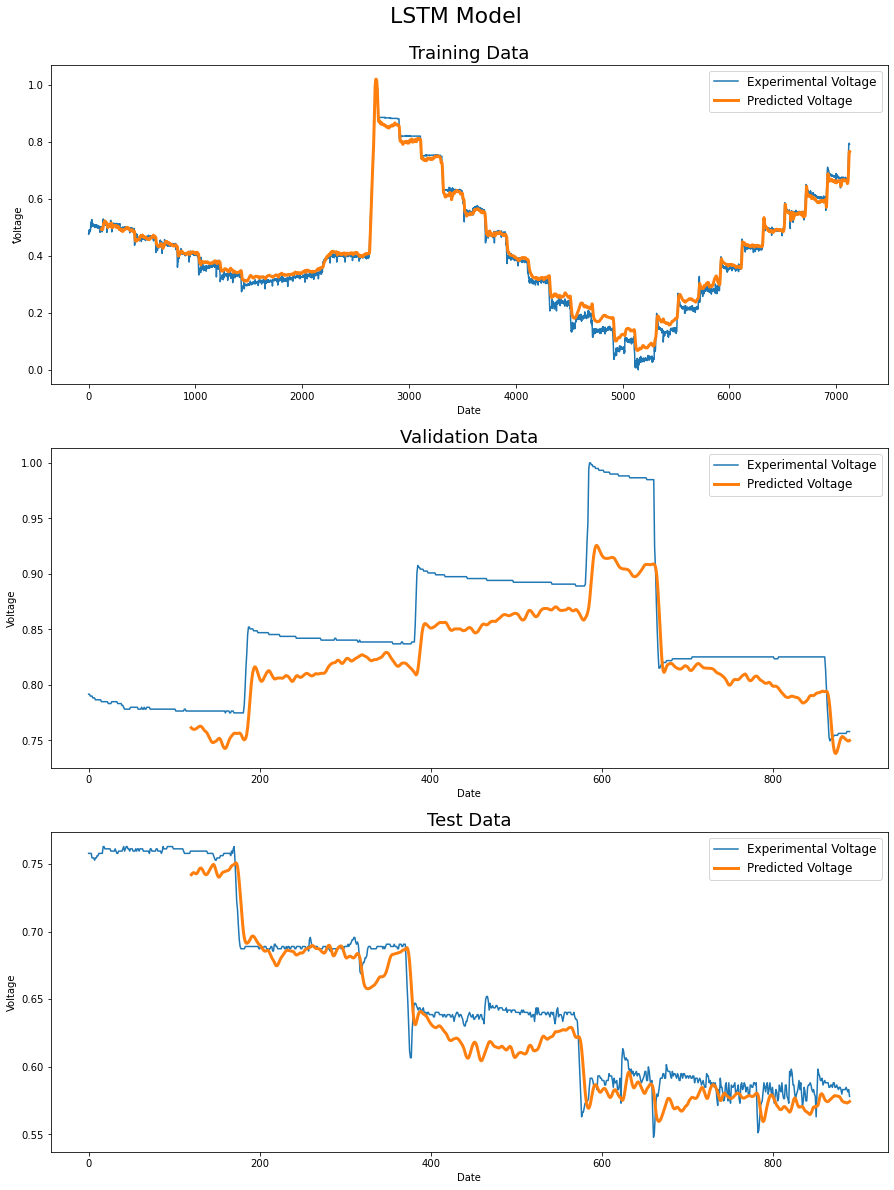

In [12]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("LSTM Model", fontsize=22)
st.set_y(0.92)
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train.values[:, -1], label='Experimental Voltage')
ax11.plot(np.arange(window_size, train_pred.shape[0]+window_size), train_pred, linewidth=3, label='Predicted Voltage')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('ٌVoltage')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(valid.values[:, -1], label='Experimental Voltage')
ax21.plot(np.arange(window_size, valid_pred.shape[0]+window_size), valid_pred, linewidth=3, label='Predicted Voltage')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test.values[:, -1], label='Experimental Voltage')
ax31.plot(np.arange(window_size, test_pred.shape[0]+window_size), test_pred, linewidth=3, label='Predicted Voltage')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Voltage')
ax31.legend(loc="best", fontsize=12)

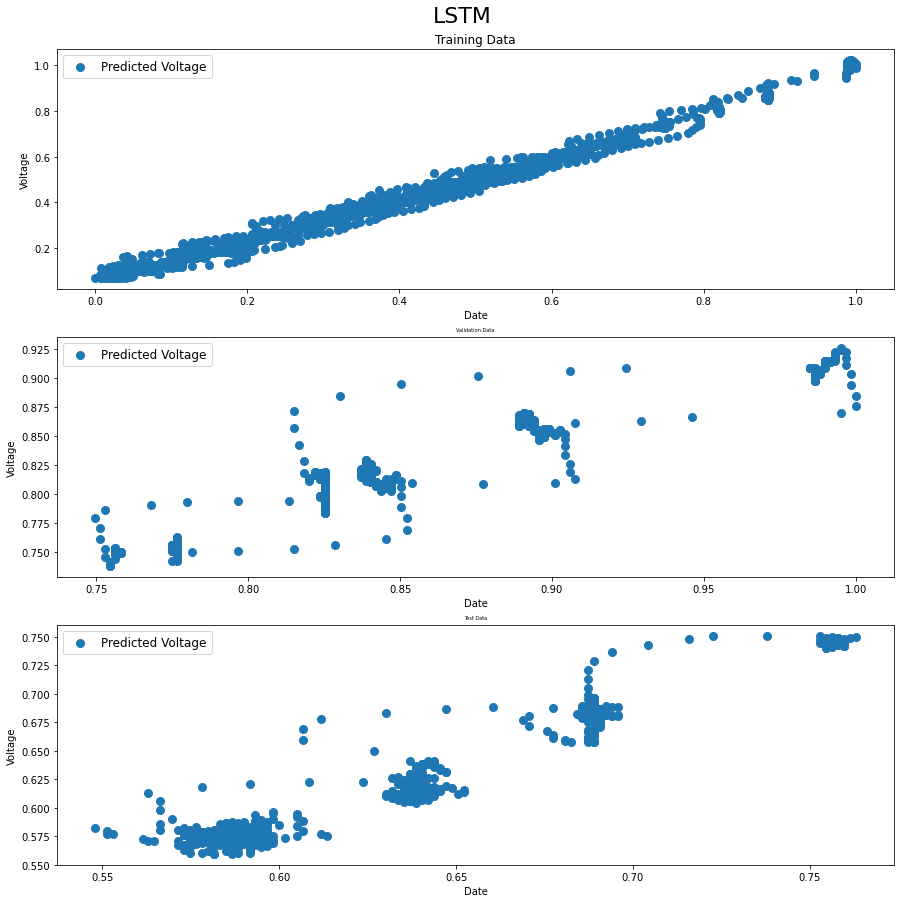

In [13]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
'''Display results'''
fig = plt.figure(figsize=(15,15))
st = fig.suptitle("LSTM", fontsize=22)
st.set_y(0.92)
#Plot training data results
ax11 = fig.add_subplot(311)
plt.scatter(np.asarray(y_train), train_pred, linewidth=3, label='Predicted Voltage')
ax11.set_title("Training Data", fontsize=12)
ax11.set_xlabel('Date')
ax11.set_ylabel('Voltage')
ax11.legend(loc="best", fontsize=12)


#Plot validation data results
ax21 = fig.add_subplot(312)
plt.scatter(np.asarray(y_valid), valid_pred, linewidth=3, label='Predicted Voltage')
ax21.set_title("Validation Data", fontsize=5)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax21 = fig.add_subplot(313)
plt.scatter(np.asarray(y_test), test_pred, linewidth=3, label='Predicted Voltage')
ax21.set_title("Test Data", fontsize=5)
ax21.set_xlabel('Date')
ax21.set_ylabel('Voltage')
ax21.legend(loc="best", fontsize=12)

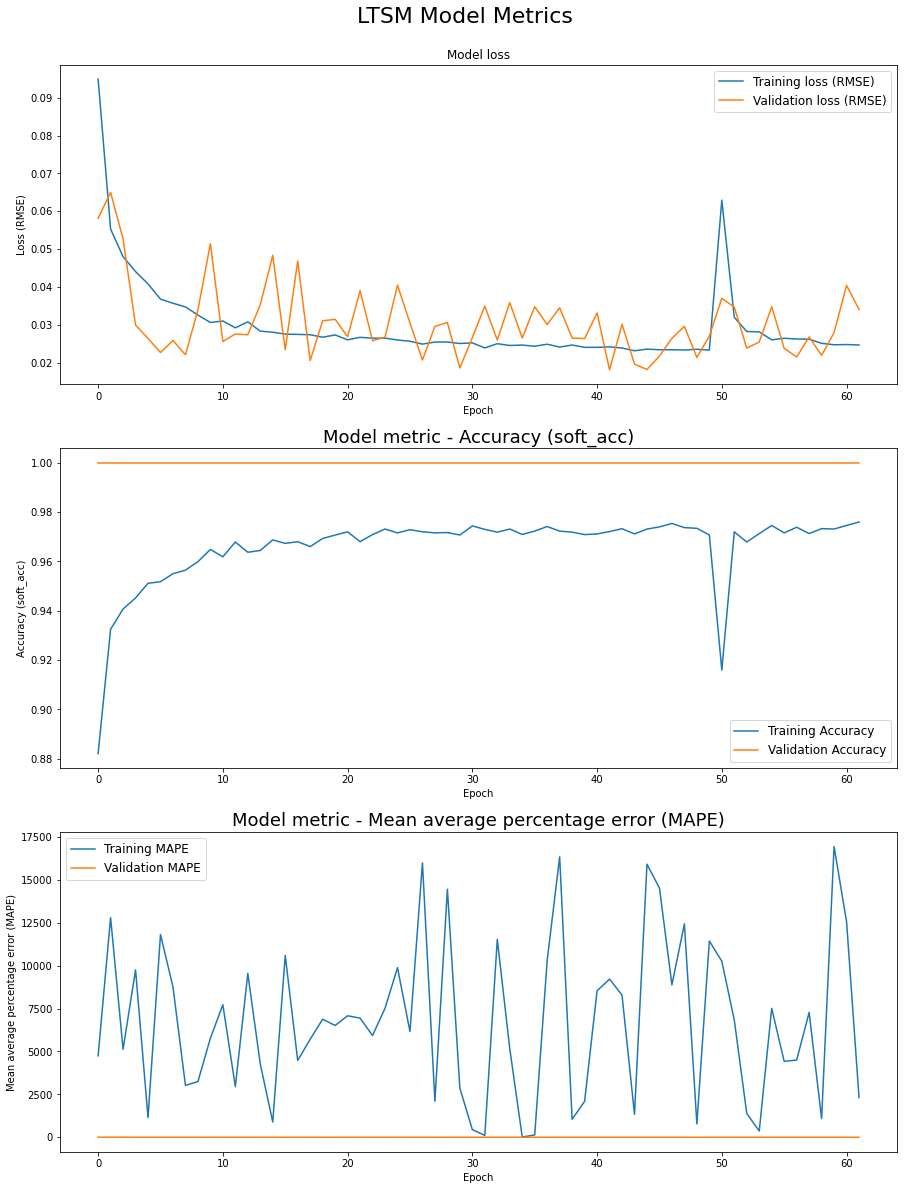

In [14]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("LTSM Model Metrics", fontsize=22)
st.set_y(0.92)
#Plot Model Loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (RMSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (RMSE)')
ax1.set_title("Model loss", fontsize=12)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (RMSE)')
ax1.legend(loc="best", fontsize=12)
#Plot Model Acurracy
ax2 = fig.add_subplot(312)
ax2.plot(history.history['soft_acc'], label='Training Accuracy')
ax2.plot(history.history['val_soft_acc'], label='Validation Accuracy')
ax2.set_title("Model metric - Accuracy (soft_acc)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (soft_acc)')
ax2.legend(loc="best", fontsize=12)
#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [15]:
print('R2_Score')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[9], valid_evaluate[9], test_evaluate[9]))

print('Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[2], valid_evaluate[2], test_evaluate[2]))

print('Mean Absolute Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[3], valid_evaluate[3], test_evaluate[3]))

print('Root Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[4], valid_evaluate[4], test_evaluate[4]))

print('Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[7], valid_evaluate[7], test_evaluate[7]))

print('Root Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[8], valid_evaluate[8], test_evaluate[8]))

print('Mean Absolute Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[5], valid_evaluate[5], test_evaluate[5]))

print('Mean Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(train_evaluate[6], valid_evaluate[6], test_evaluate[6]))

R2_Score
----------------------------------------
train error: -1715.736572265625 |
valid error: -43405.58984375 |
test error : -35.074867248535156

Mean Squared Error
----------------------------------------
train error: 0.0005421409150585532 |
valid error: 0.0015312788309529424 |
test error : 0.00028326339088380337

Mean Absolute Error
----------------------------------------
train error: 0.017720524221658707 |
valid error: 0.032768648117780685 |
test error : 0.013455835171043873

Root Mean Squared Error
----------------------------------------
train error: 0.019328288733959198 |
valid error: 0.03311081975698471 |
test error : 0.014988027513027191

Mean Squared Logarithmic Error
----------------------------------------
train error: 0.00035079382359981537 |
valid error: 0.00043023363105021417 |
test error : 0.00010700910206651315

Root Mean Squared Logarithmic Error
----------------------------------------
train error: 0.013455629348754883 |
valid error: 0.017586924135684967 |
test er

In [16]:
model.save('LSTM.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/repli